In [1]:
import pandas as pd
import numpy as np
import os
import time

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import pickle

from sklearn.linear_model import LogisticRegression  
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, classification_report

from xgboost import XGBClassifier

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# https://seaborn.pydata.org/tutorial/aesthetics.html
sns.set(
    style='ticks', 
    context='talk', 
    font_scale=0.8, 
    rc={'figure.figsize': (8,6)})

In [2]:
# load scraped dataset
matches = pd.read_csv("matches.csv")

In [3]:
matches.head()

,date,time,comp,round,day,venue,result,gf,ga,opponent,...,match report,notes,sh,sot,dist,fk,pk,pkatt,season,team
0,2023-08-12,12:30,Premier League,Matchweek 1,Sat,Home,W,2.0,1.0,Nott'ham Forest,...,Match Report,NaN,15.0,7.0,19.1,0.0,0,0,2024,Arsenal
1,2023-08-21,20:00,Premier League,Matchweek 2,Mon,Away,W,1.0,0.0,Crystal Palace,...,Match Report,NaN,13.0,2.0,16.4,0.0,1,1,2024,Arsenal
2,2023-08-26,15:00,Premier League,Matchweek 3,Sat,Home,D,2.0,2.0,Fulham,...,Match Report,NaN,18.0,9.0,13.8,0.0,1,1,2024,Arsenal
3,2023-09-03,16:30,Premier League,Matchweek 4,Sun,Home,W,3.0,1.0,Manchester Utd,...,Match Report,NaN,17.0,5.0,15.0,0.0,0,0,2024,Arsenal
4,2023-09-17,16:30,Premier League,Matchweek 5,Sun,Away,W,1.0,0.0,Everton,...,Match Report,NaN,13.0,4.0,17.4,0.0,0,0,2024,Arsenal


In [4]:
matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3609 entries, 0 to 3608
Data columns (total 27 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          3609 non-null   object 
 1   time          3609 non-null   object 
 2   comp          3609 non-null   object 
 3   round         3609 non-null   object 
 4   day           3609 non-null   object 
 5   venue         3609 non-null   object 
 6   result        3606 non-null   object 
 7   gf            3606 non-null   float64
 8   ga            3606 non-null   float64
 9   opponent      3609 non-null   object 
 10  xg            3606 non-null   float64
 11  xga           3606 non-null   float64
 12  poss          3606 non-null   float64
 13  attendance    2724 non-null   float64
 14  captain       3606 non-null   object 
 15  formation     3606 non-null   object 
 16  referee       3606 non-null   object 
 17  match report  3606 non-null   object 
 18  notes         3 non-null    

In [5]:
# check for duplicated entries
matches[matches.duplicated()]

,date,time,comp,round,day,venue,result,gf,ga,opponent,...,match report,notes,sh,sot,dist,fk,pk,pkatt,season,team


In [6]:
# quick check of descriptive statistics of numerical features
matches.describe().T

,count,mean,std,min,25%,50%,75%,max
gf,3606.0,1.422629,1.292453,0.0,0.0,1.0,2.0,9.0
ga,3606.0,1.422629,1.292453,0.0,0.0,1.0,2.0,9.0
xg,3606.0,1.385857,0.819147,0.0,0.8,1.3,1.9,7.0
xga,3606.0,1.385857,0.819147,0.0,0.8,1.3,1.9,7.0
poss,3606.0,50.001109,12.768590,18.0,40.0,50.0,60.0,82.0
attendance,2724.0,38654.809838,17033.289603,2000.0,26836.0,36386.0,53135.0,75546.0
sh,3609.0,12.523414,5.485626,0.0,8.0,12.0,16.0,34.0
sot,3609.0,4.194791,2.436446,0.0,2.0,4.0,6.0,15.0
dist,3605.0,17.291650,3.042391,5.3,15.3,17.2,19.1,39.9
fk,3606.0,0.438713,0.656126,0.0,0.0,0.0,1.0,4.0


In [7]:
# quick check of descriptive statistics of categorical features
matches.describe(include='object').T

,count,unique,top,freq
date,3609,582,2023-05-28,20
time,3609,22,15:00,1032
comp,3609,1,Premier League,3609
round,3609,38,Matchweek 1,100
day,3609,7,Sat,1632
venue,3609,2,Away,1805
result,3606,3,W,1394
opponent,3609,26,Aston Villa,181
captain,3606,172,Lewis Dunk,158
formation,3606,22,4-2-3-1,1027


In [8]:
# number of unique values in each column
columns = matches.columns
for col in range(len(columns)):
    n_unique = matches[columns[col]].nunique()
    if n_unique > 1:
        print(f"There are {n_unique} uniques {' '.join(columns[col].split('_'))}s in {columns[col]} column")
    else:
        print(f"There is {n_unique} unique {' '.join(columns[col].split('_'))} in {columns[col]} column")

There are 582 uniques dates in date column
There are 22 uniques times in time column
There is 1 unique comp in comp column
There are 38 uniques rounds in round column
There are 7 uniques days in day column
There are 2 uniques venues in venue column
There are 3 uniques results in result column
There are 10 uniques gfs in gf column
There are 10 uniques gas in ga column
There are 26 uniques opponents in opponent column
There are 50 uniques xgs in xg column
There are 50 uniques xgas in xga column
There are 65 uniques posss in poss column
There are 1257 uniques attendances in attendance column
There are 172 uniques captains in captain column
There are 22 uniques formations in formation column
There are 34 uniques referees in referee column
There is 1 unique match report in match report column
There is 1 unique notes in notes column
There are 34 uniques shs in sh column
There are 16 uniques sots in sot column
There are 191 uniques dists in dist column
There are 5 uniques fks in fk column
The

In [9]:
matches.shape

(3609, 27)

In [10]:
# proportion of missing values in the datatset
matches.isnull().sum() *100 / len(matches)

date             0.000000
time             0.000000
comp             0.000000
round            0.000000
day              0.000000
venue            0.000000
result           0.083126
gf               0.083126
ga               0.083126
opponent         0.000000
xg               0.083126
xga              0.083126
poss             0.083126
attendance      24.522028
captain          0.083126
formation        0.083126
referee          0.083126
match report     0.083126
notes           99.916874
sh               0.000000
sot              0.000000
dist             0.110834
fk               0.083126
pk               0.000000
pkatt            0.000000
season           0.000000
team             0.000000
dtype: float64

Dropping the `attendance`, `comp`, `match report`,`round` columns

In [11]:
matches.drop(['attendance','comp','notes','match report','round','dist'], axis='columns', inplace=True)

In [12]:
matches.shape

(3609, 21)

In [13]:
# proportion of missing values in the datatset
matches.isnull().sum() *100 / len(matches)

date         0.000000
time         0.000000
day          0.000000
venue        0.000000
result       0.083126
gf           0.083126
ga           0.083126
opponent     0.000000
xg           0.083126
xga          0.083126
poss         0.083126
captain      0.083126
formation    0.083126
referee      0.083126
sh           0.000000
sot          0.000000
fk           0.083126
pk           0.000000
pkatt        0.000000
season       0.000000
team         0.000000
dtype: float64

In [14]:
# Drop rows with missing vlaues
matches.dropna(axis=0, inplace=True)

In [15]:
matches.isnull().sum()

date         0
time         0
day          0
venue        0
result       0
gf           0
ga           0
opponent     0
xg           0
xga          0
poss         0
captain      0
formation    0
referee      0
sh           0
sot          0
fk           0
pk           0
pkatt        0
season       0
team         0
dtype: int64

In [16]:
matches.shape

(3606, 21)

In [17]:
matches.head(2)

,date,time,day,venue,result,gf,ga,opponent,xg,xga,...,captain,formation,referee,sh,sot,fk,pk,pkatt,season,team
0,2023-08-12,12:30,Sat,Home,W,2.0,1.0,Nott'ham Forest,0.8,1.2,...,Martin Ødegaard,4-3-3,Michael Oliver,15.0,7.0,0.0,0,0,2024,Arsenal
1,2023-08-21,20:00,Mon,Away,W,1.0,0.0,Crystal Palace,2.0,1.0,...,Martin Ødegaard,4-3-3,David Coote,13.0,2.0,0.0,1,1,2024,Arsenal


In [18]:
matches.columns

Index(['date', 'time', 'day', 'venue', 'result', 'gf', 'ga', 'opponent', 'xg',
       'xga', 'poss', 'captain', 'formation', 'referee', 'sh', 'sot', 'fk',
       'pk', 'pkatt', 'season', 'team'],
      dtype='object')

## Exploratory Data Analysis

Taking each columns that we will might give us information on target which is the match result

In [19]:
matches.columns

Index(['date', 'time', 'day', 'venue', 'result', 'gf', 'ga', 'opponent', 'xg',
       'xga', 'poss', 'captain', 'formation', 'referee', 'sh', 'sot', 'fk',
       'pk', 'pkatt', 'season', 'team'],
      dtype='object')

In [20]:
data_dict = {"date":"local match date",
                   "time":"local time for kick-off",
                   "day":"day of match",
                   "venue":"match venue",
                   "result":"match result",
                   "gf":"goal score by team",
                   "ga":"goal scored against team",
                   "opponent":"team's opponent",
                   "xg":"total goals expected",
                   "xga":"expected goals against",
                   "poss": "teams's possession",
                   "captain":"team's captain",
                   "formation":"team's formation",
                   "refree":"officiating refree",
                   "sh":"total shots",
                   "sot":"total short on target",
                   "fk":"shots from freekicks",
                    "pk":"penalty kicks made",
                    "pkatt":"peanlty kicks attempted",
                    "season":"current season",
                    "team":"team name"                   
                   }

data_dict_df = pd.DataFrame(data_dict.items(), columns=["columns","meaning"])
data_dict_df

,columns,meaning
0,date,local match date
1,time,local time for kick-off
2,day,day of match
3,venue,match venue
4,result,match result
5,gf,goal score by team
6,ga,goal scored against team
7,opponent,team's opponent
8,xg,total goals expected
9,xga,expected goals against


Columns to work with:
- day
- venue
- poss
- sh
- sot
- fk
- opponent
- captain
- formation

In [21]:
matches['result'].value_counts(dropna=False)

result
W    1394
L    1394
D     818
Name: count, dtype: int64

In [22]:
# matches['result'] =  matches['result'].astype('category').cat.codes
# matches['result'].value_counts()

In [23]:
# plots a box plot
def plot_boxplot(df, col, target):
    """
    Returns a box plot by taking in three arguements:
        df: The dataframe 
        col: The column of interest
        target: The target column.
    """
    plt.figure(figsize=(8, 5))
    feature = df[col]
    target = df[target]
    sns.boxplot(data=df, y=feature, x=target)
    plt.title(col)    
    plt.show()
    
# plots a distribution plot
def plot_displot(df, col, extra_col=None, hue=None):
    """
    Returns a distribution plot by taking in two complusory keywords
    and two optional arguements:
        df: The dataframe 
        col: The column of interest
        extra_col:  Variables that define subsets to plot on different facets
        hue: This parameter takes a column name for colour encoding.
    """
    feature = df[col]
    ax1 = sns.displot(data=df, x=feature, hue=hue,col=extra_col,height=5, aspect=1.5,kde=True)
    ax1.fig.subplots_adjust(top=.8)
    ax1.fig.suptitle('Distribution of ' + col)



# plots a countplot
def plot_countplot(data1, data2, col, title, hue=None):
    
    data1 = data1
    data2 = data2
    col = col
    if len(data2.index[0]) > 5:
        if hue is None:
            fig = plt.figure(figsize=(12,9))
            ax = sns.countplot(y=data1[col],
                            order=data2.index,
                            lw=1,
                            palette='cividis',
                            edgecolor=['k']*data1[col].nunique()
                        )
        else:
            fig = plt.figure(figsize=(12,9))
            ax = sns.countplot(y=data1[col],
                            hue=hue,
                            order=data2.index,
                            lw=1,
                            palette='cividis',
                            edgecolor=['k']*data1[col].nunique()
                        )
    else:
        if hue is None:
            fig = plt.figure(figsize=(12,9))
            ax = sns.countplot(x=data1[col],
                            order=data2.index,
                            lw=1,
                            palette='cividis',
                            edgecolor=['k']*data1[col].nunique()
                        )
        else:
            fig = plt.figure(figsize=(12,9))
            ax = sns.countplot(x=data1[col],
                            hue=hue,
                            order=data2.index,
                            lw=1,
                            palette='cividis',
                            edgecolor=['k']*data1[col].nunique()
                        )

        
    plt.title(title,fontsize=12,weight='bold')

### Days

In [24]:
count_days = matches['day'].value_counts()/2
count_days

day
Sat    815.0
Sun    492.0
Wed    154.0
Mon    110.0
Tue     99.0
Thu     75.0
Fri     58.0
Name: count, dtype: float64

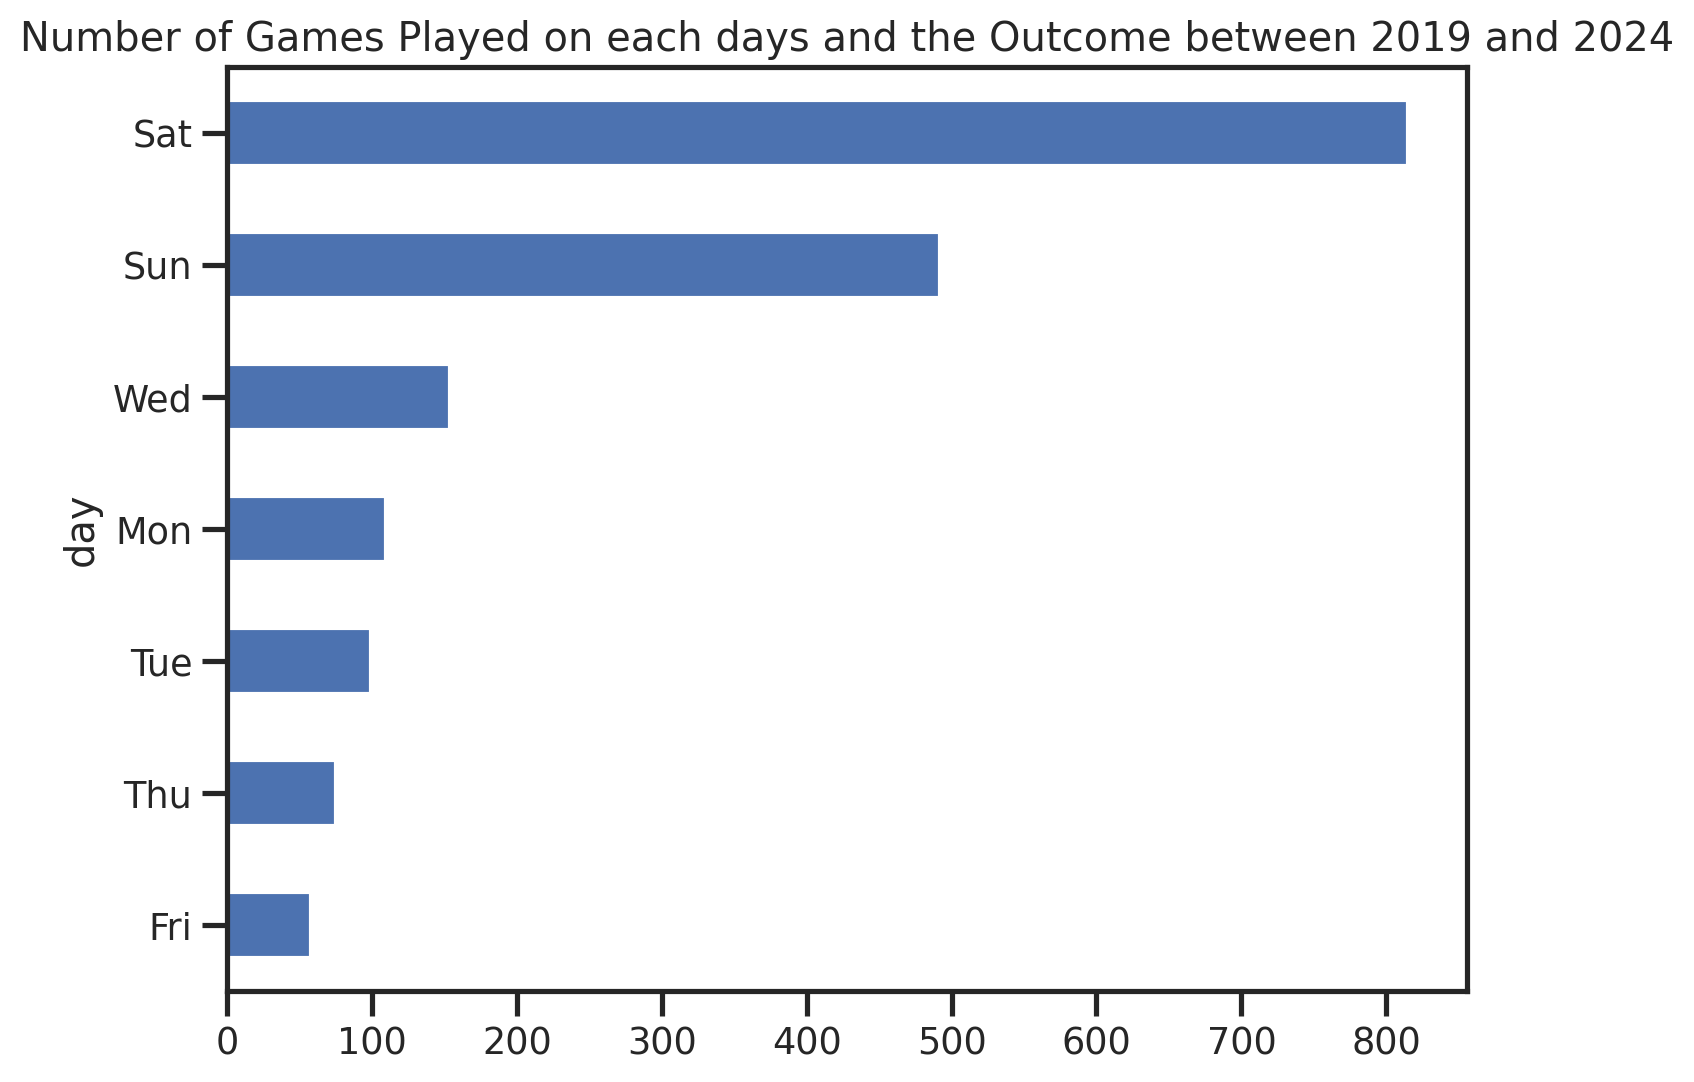

In [25]:
count_days.sort_values(ascending=True).plot(kind="barh", title="Number of Games Played on each days and the Outcome between 2019 and 2024");

### Captains

In [26]:
captain_count = matches['captain'].value_counts()/2
len(captain_count.index[0])

10

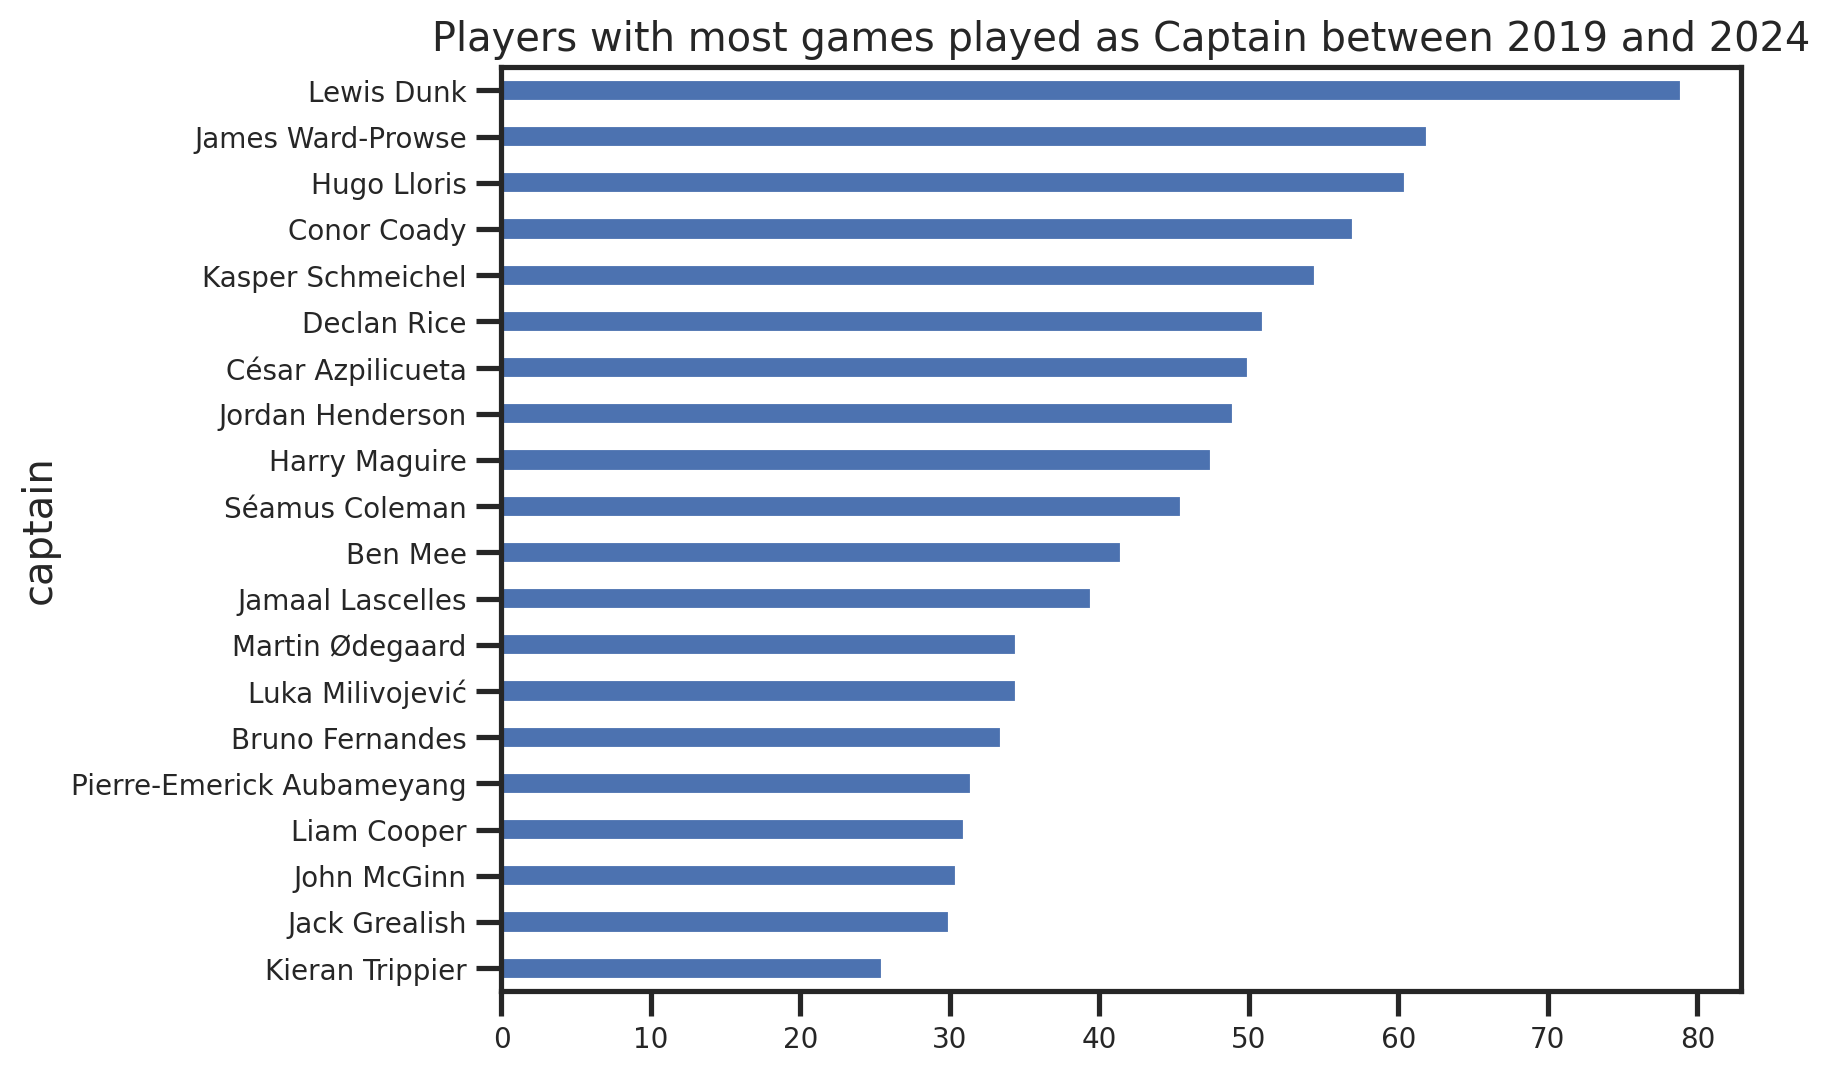

In [27]:
captain_count[:20].sort_values(ascending=True).plot(kind='barh',title= "Players with most games played as Captain between 2019 and 2024", fontsize=10);

In [28]:
print(len(matches[matches['captain'].str.contains('Bruno Fernandes')]))
print(len(matches[matches['captain'].str.contains('Harry Maguire')]))

67
95


In [29]:
print(f"Bruno Fernandes's Caps: {matches[matches['captain'].str.contains('Bruno Fernandes')]['year'].unique()}")
print(f"Harry Maguire's Caps: {matches[matches['captain'].str.contains('Harry Maguire')]['year'].unique()}")

KeyError: 'year'

I'm a Manchester united fan, it's time I compare Bruno's and Maguire's Match results as captains

In [ ]:
bruno_maguire_caps = matches[(matches['captain'].str.contains('Bruno Fernandes')) | (matches['captain'].str.contains('Harry Maguire'))]

In [ ]:
bruno_maguire_caps.groupby('captain')['result'].value_counts()

captain          result
Bruno Fernandes  W         34
                 L         20
                 D         13
Harry Maguire    W         53
                 D         23
                 L         19
Name: count, dtype: int64

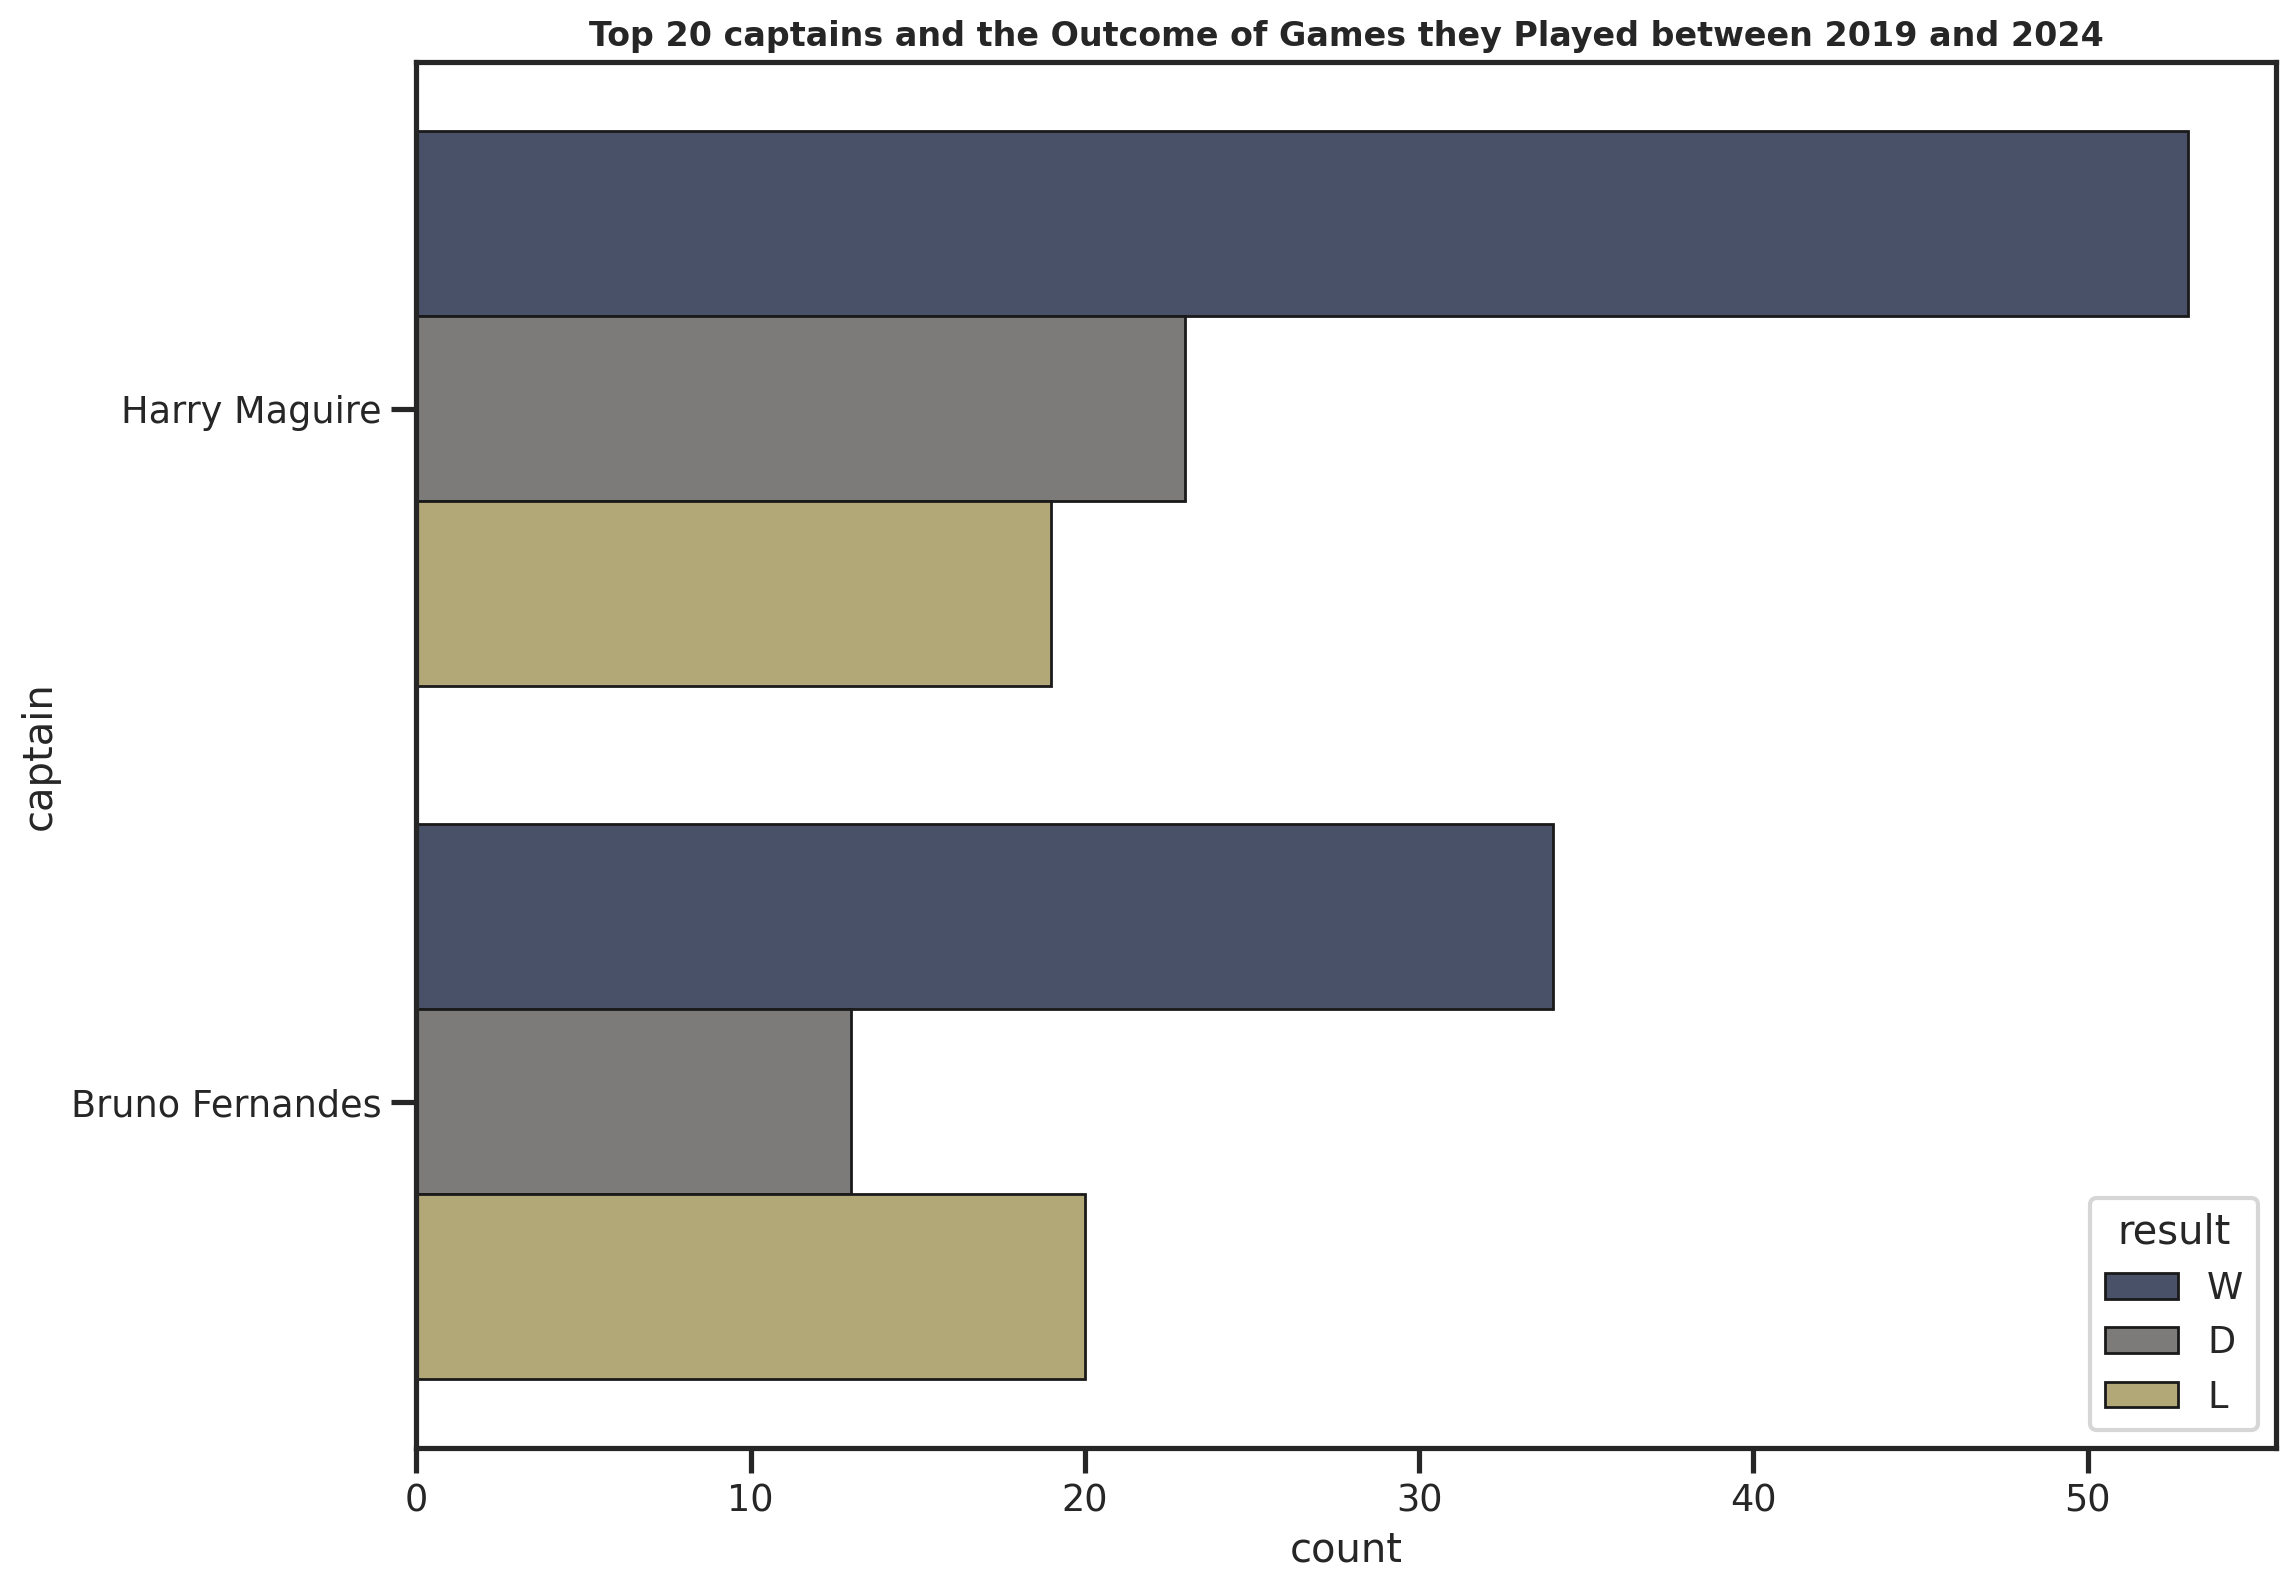

In [ ]:
plot_countplot(bruno_maguire_caps, bruno_maguire_caps['captain'].value_counts(), "captain", "Top 20 captains and the Outcome of Games they Played between 2019 and 2024", matches['result'])

### Total Shots

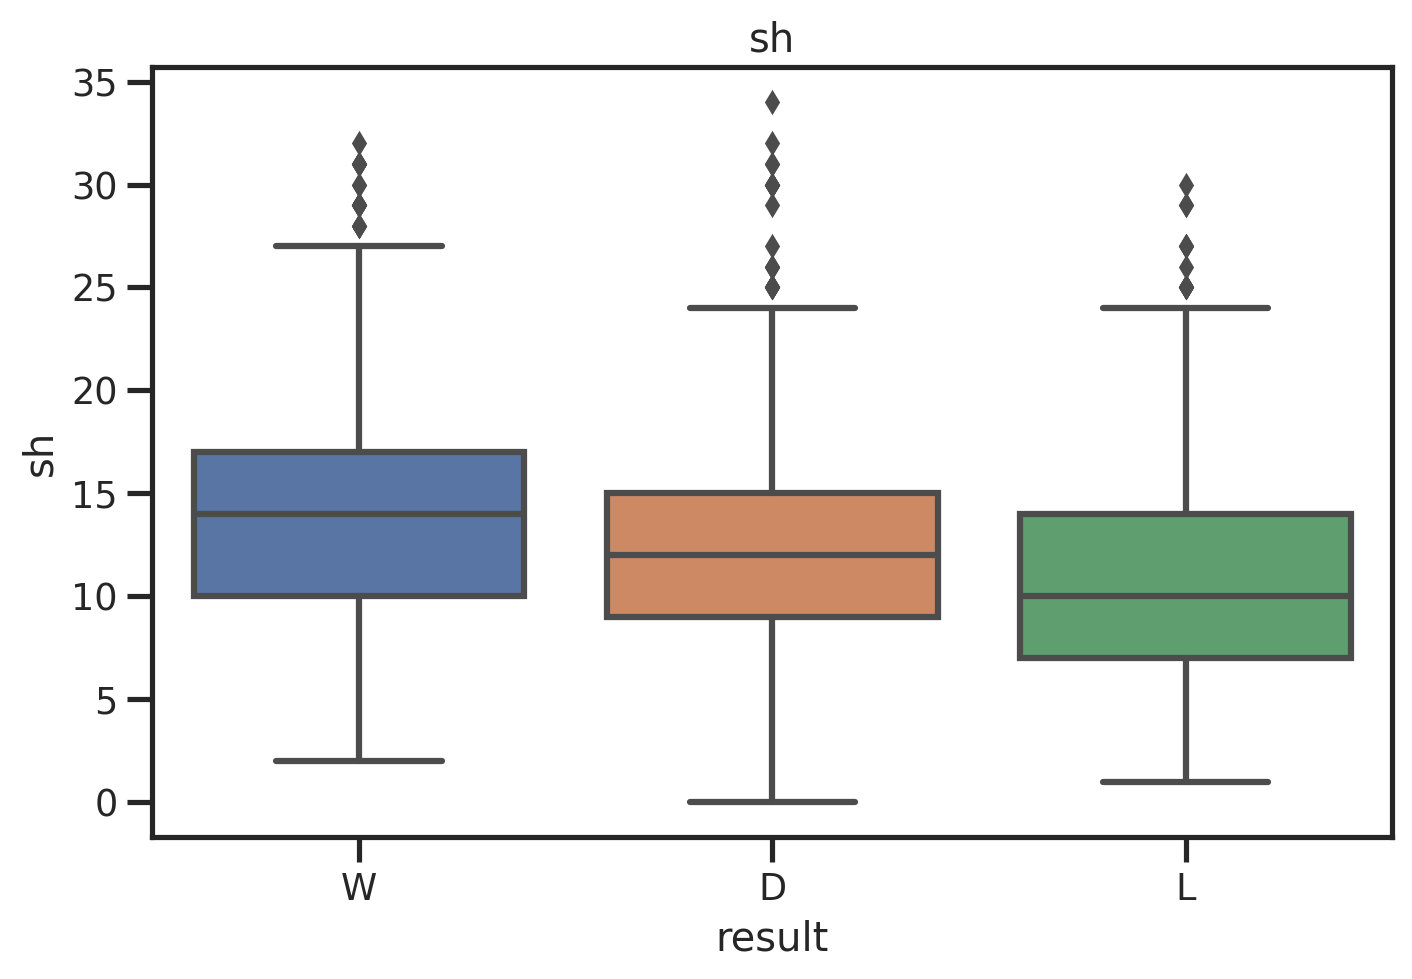

In [ ]:
plot_boxplot(matches, 'sh', 'result')

### Shots on target

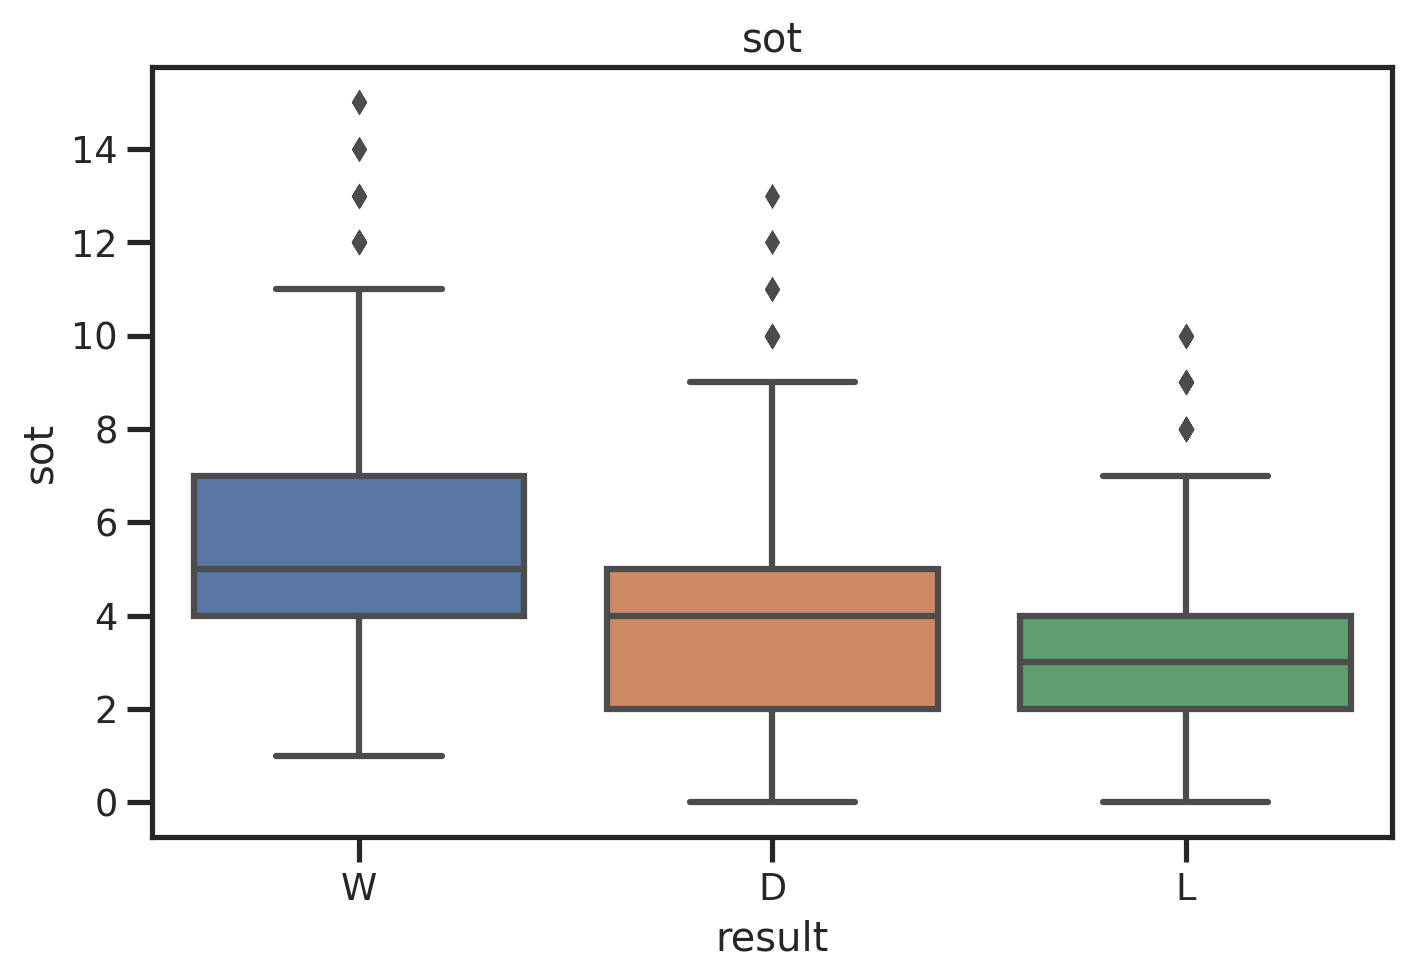

In [ ]:
plot_boxplot(matches, 'sot', 'result')

let's check all columns if they need cleaning before contiuing the EDA

In [ ]:
matches.dtypes

date           datetime64[ns]
time           datetime64[ns]
day                    object
venue                  object
result                 object
gf                      int64
ga                      int64
opponent               object
xg                    float64
xga                   float64
poss                    int64
captain                object
formation              object
referee                object
sh                      int64
sot                     int64
fk                      int64
pk                      int64
pkatt                   int64
season                  int64
team                   object
total_goals             int64
year                   object
dtype: object

In [ ]:
# Convert 'date' column to datetime
matches['date'] = pd.to_datetime(matches['date'])

In [ ]:
# Convert 'time' column to datetime
matches['time'] = pd.to_datetime(matches['time'], format='%H:%M')

In [ ]:
matches['day'].unique()

array(['Sat', 'Mon', 'Sun', 'Tue', 'Thu', 'Wed', 'Fri'], dtype=object)

In [ ]:
matches['venue'].unique()

array(['Home', 'Away'], dtype=object)

In [ ]:
print(matches['gf'].unique())
matches['gf'] = matches['gf'].astype(int)

[2 1 3 4 5 0 6 8 9 7]


In [ ]:
print(matches['ga'].unique())
matches['ga'] = matches['ga'].astype(int)

[1 0 2 3 4 5 6 8 7 9]


Renaming team names to match the team column

In [ ]:
[i for i in sorted(matches['opponent'].unique()) if i not in sorted(matches['team'].unique())]

[]

In [ ]:
[i for i in sorted(matches['team'].unique()) if i not in sorted(matches['opponent'].unique())]

[]

In [ ]:
matches['opponent'].replace(['Brighton','Manchester Utd','Newcastle Utd',"Nott'ham Forest",'Sheffield Utd','Tottenham','West Brom','West Ham','Wolves'],
                            ['Brighton and Hove Albion','Manchester United','Newcastle United','Nottingham Forest','Sheffield United','Tottenham Hotspur',
                             'West Bromwich Albion','West Ham United','Wolverhampton Wanderers'], inplace=True)

In [ ]:
matches['opponent'].unique()

array(['Nottingham Forest', 'Crystal Palace', 'Fulham',
       'Manchester United', 'Everton', 'Tottenham Hotspur', 'Bournemouth',
       'Manchester City', 'Chelsea', 'Sheffield United',
       'Newcastle United', 'Burnley', 'Brentford',
       'Wolverhampton Wanderers', 'Luton Town', 'Aston Villa',
       'Brighton and Hove Albion', 'Liverpool', 'West Ham United',
       'Arsenal', 'Southampton', 'Leicester City', 'Leeds United',
       'Norwich City', 'Watford', 'West Bromwich Albion'], dtype=object)

In [ ]:
matches['xg'].unique()

array([0.8, 2. , 3.2, 2.3, 1. , 1.8, 3.4, 0.4, 2.8, 0.6, 1.6, 2.2, 1.4,
       0.7, 2.7, 3.3, 1.2, 3.5, 3.6, 1.3, 3. , 0.9, 2.5, 2.6, 1.7, 2.1,
       7. , 1.5, 2.9, 1.9, 0.5, 4. , 2.4, 1.1, 3.8, 4.1, 0.2, 0.3, 3.9,
       3.1, 3.7, 0.1, 0. , 4.3, 4.4, 5.2, 4.2, 4.6, 5.9, 4.7])

In [ ]:
matches['xga'].unique()

array([1.2, 1. , 0.6, 0.9, 0.3, 1.4, 0.5, 1.3, 0. , 1.1, 0.7, 0.4, 0.2,
       2. , 2.2, 2.3, 0.1, 0.8, 1.6, 1.7, 3.5, 2.9, 1.8, 2.7, 3.3, 2.5,
       2.6, 1.5, 2.1, 4.1, 3.2, 4. , 2.4, 3.6, 3. , 1.9, 2.8, 3.1, 3.8,
       7. , 3.7, 3.4, 3.9, 4.2, 5.2, 4.4, 4.3, 5.9, 4.6, 4.7])

In [ ]:
print(matches['poss'].unique())
matches['poss'] = matches['poss'].astype(int)

[78 53 71 55 74 47 57 49 56 67 58 63 64 66 61 48 73 60 43 70 80 35 41 65
 36 54 77 72 59 75 76 68 52 50 62 69 79 51 37 39 38 46 32 40 45 44 42 27
 25 22 26 30 31 28 29 34 23 33 24 21 20 81 19 82 18]


In [ ]:
matches[~(matches['captain'].str.contains('^[a-zA-Z0-9]'))]['captain'].unique()

array(['İlkay Gündoğan', 'Étienne Capoue'], dtype=object)

In [ ]:
matches['formation'].unique()

array(['4-3-3', '4-2-3-1', '3-2-4-1', '3-4-3', '4-1-4-1', '4-4-2',
       '4-2-2-2', '4-4-1-1', '3-5-2', '5-3-2', '4-1-2-1-2', '4-2-4',
       '4-3-2-1', '4-3-1-2', '5-4-1', '4-5-1', '3-4-1-2', '3-5-1-1',
       '3-3-3-1', '3-1-4-2', '4-1-3-2'], dtype=object)

In [ ]:
matches[matches['formation'].str.contains('4-1-2-1-2◆')]

,date,time,day,venue,result,gf,ga,opponent,xg,xga,...,referee,sh,sot,fk,pk,pkatt,season,team,total_goals,year


In [ ]:
matches['formation'].replace(["4-1-2-1-2◆","3-4-3◆","4-2-4-0"], ["4-1-2-1-2", "3-4-3", "4-2-4"], inplace=True)

In [ ]:
matches['formation'].unique()

array(['4-3-3', '4-2-3-1', '3-2-4-1', '3-4-3', '4-1-4-1', '4-4-2',
       '4-2-2-2', '4-4-1-1', '3-5-2', '5-3-2', '4-1-2-1-2', '4-2-4',
       '4-3-2-1', '4-3-1-2', '5-4-1', '4-5-1', '3-4-1-2', '3-5-1-1',
       '3-3-3-1', '3-1-4-2', '4-1-3-2'], dtype=object)

In [ ]:
matches.groupby('formation')['result'].value_counts().sort_values(ascending=False)[:20]

formation  result
4-2-3-1    W         432
4-3-3      W         390
4-2-3-1    L         380
4-3-3      L         222
4-2-3-1    D         215
4-4-2      L         196
4-3-3      D         170
3-4-3      W         164
           L         150
4-4-2      W         139
           D         110
3-5-2      L         110
3-4-3      D         102
4-1-4-1    L          80
3-5-2      W          57
4-1-4-1    W          53
4-4-1-1    L          52
3-5-2      D          46
5-3-2      L          46
4-1-4-1    D          45
Name: count, dtype: int64

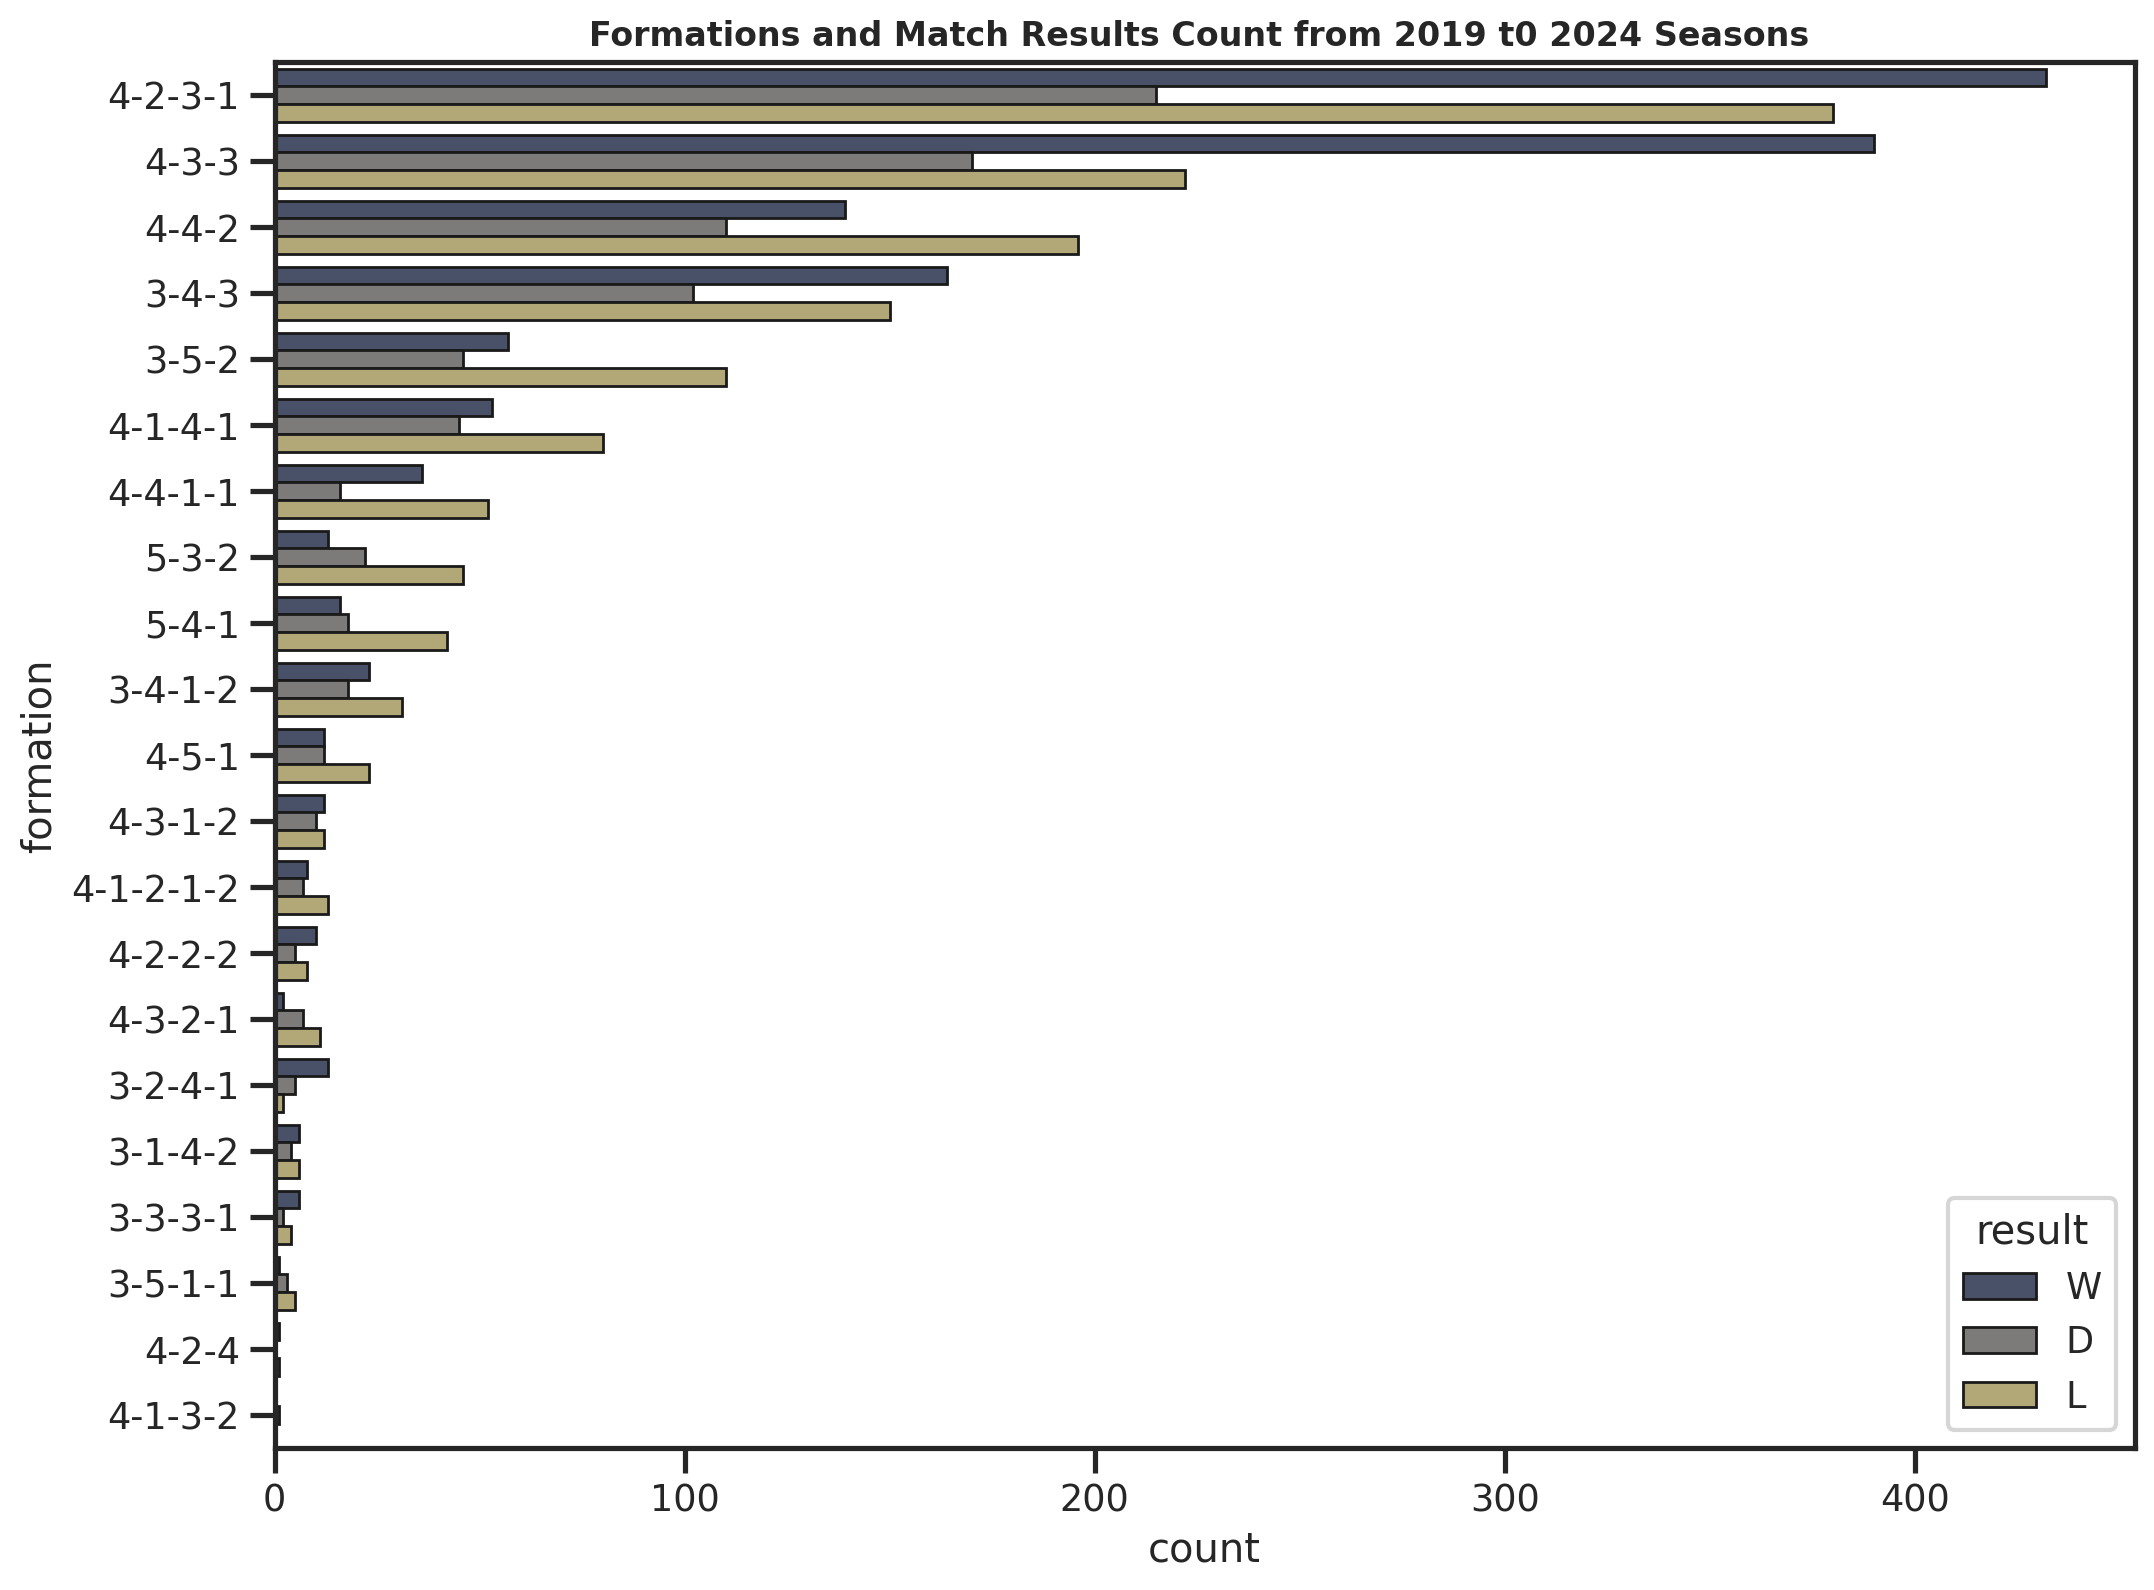

In [ ]:
plot_countplot(matches, matches['formation'].value_counts(), 'formation', 'Formations and Match Results Count from 2019 t0 2024 Seasons ', matches['result'])

In [ ]:
matches['referee'].unique()

array(['Michael Oliver', 'David Coote', 'Paul Tierney', 'Anthony Taylor',
       'Simon Hooper', 'Robert Jones', 'Michael Salisbury',
       'Chris Kavanagh', 'Tim Robinson', 'Stuart Attwell', 'Peter Bankes',
       'Samuel Barrott', 'Jarred Gillett', 'Joshua Smith', 'Craig Pawson',
       'Thomas Bramall', 'John Brooks', 'Andy Madley', 'Darren England',
       'Lewis Smith', 'Tony Harrington', 'Graham Scott', 'Darren Bond',
       'Rebecca Welch', 'Robert Madley', 'Samuel Allison', 'Sunny Singh',
       'Andre Marriner', 'Martin Atkinson', 'Jonathan Moss',
       'Kevin Friend', 'Mike Dean', 'Lee Mason', 'Oliver Langford'],
      dtype=object)

In [ ]:
refree_count = matches['referee'].value_counts()/2

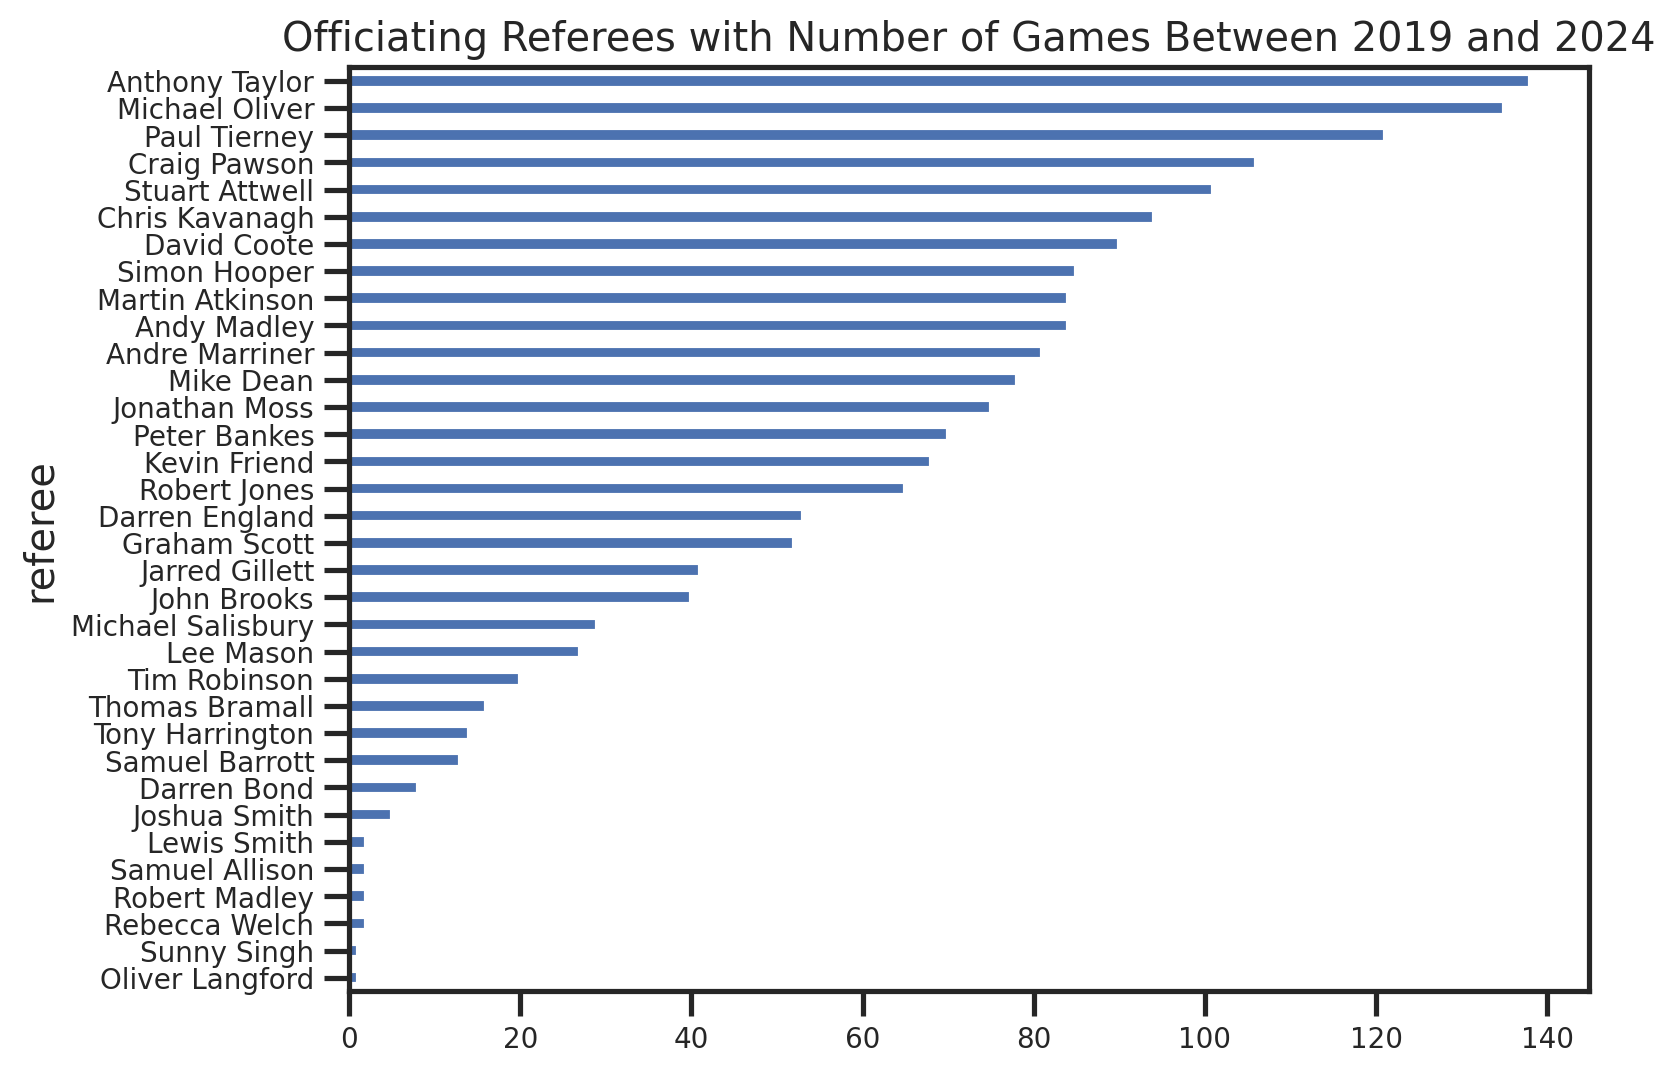

In [ ]:
refree_count.sort_values(ascending=True).plot(kind='barh',fontsize=10, title="Officiating Referees with Number of Games Between 2019 and 2024");

In [ ]:
print(matches['sh'].unique())
matches['sh'] = matches['sh'].astype(int)

[15. 13. 18. 17. 12. 14. 16. 19. 23. 26. 30. 21. 24. 22. 25.  9.  8. 34.
 32. 27. 10. 29.  6.  7.  4. 20.  2. 31. 11. 28.  3.  5.  1.  0.]


In [ ]:
print(matches['sot'].unique())
matches['sot'] = matches['sot'].astype(int)

[ 7.  2.  9.  5.  4.  6.  3.  1.  8. 11. 10. 12. 13.  0. 15. 14.]


In [ ]:
print(matches['fk'].unique())
matches['fk'] = matches['fk'].astype(int)

[0 1 2 3 4]


In [ ]:
print(matches['pk'].unique())

[0 1 2 3]


In [ ]:
print(matches['pkatt'].unique())

[0 1 2 3]


In [ ]:
# check if each value in both columns are equal at each index
{True for i, j in zip(matches['pk'], matches['pkatt']) if i == j}

{True}

In [ ]:
matches['season'].unique()

array([2024, 2023, 2022, 2021, 2020])

Create a total goals column and a year column

In [ ]:
matches['total_goals'] = matches['ga'] + matches['gf']

In [ ]:
matches['year'] = matches['date'].apply(lambda x: x.strftime('%Y'))

In [ ]:
x = matches.query("year=='2023'")
x.query("opponent=='Nottingham Forest'").iloc[0].to_frame().T

,date,time,day,venue,result,gf,ga,opponent,xg,xga,...,referee,sh,sot,fk,pk,pkatt,season,team,total_goals,year
0,2023-08-12 00:00:00,1900-01-01 12:30:00,Sat,Home,W,2,1,Nottingham Forest,0.8,1.2,...,Michael Oliver,15,7,0,0,0,2024,Arsenal,3,2023


In [ ]:
x = matches.query("year=='2023'")
x.query("opponent=='Nottingham Forest'").iloc[0].to_frame().T

In [132]:
matches['year'].value_counts() / 2

year
2023    412.0
2021    408.0
2022    361.0
2020    336.0
2019    199.0
2024     87.0
Name: count, dtype: float64

In [ ]:
plot_countplot(matches, matches['year'].value_counts()/2, 'year','Number of game played in a year')

In [126]:
matches['year']

0       2023
1       2023
2       2023
3       2023
4       2023
        ... 
3604    2020
3605    2020
3606    2020
3607    2020
3608    2020
Name: year, Length: 3606, dtype: object

In [129]:
matches.groupby('year')['total_goals'].sum()

year
2019    1118
2020    1818
2021    2216
2022    2050
2023    2444
2024     614
Name: total_goals, dtype: int64

In [127]:
matches.query("year=='2024'")

,date,time,day,venue,result,gf,ga,opponent,xg,xga,...,referee,sh,sot,fk,pk,pkatt,season,team,total_goals,year
20,2024-01-20,1900-01-01 12:30:00,Sat,Home,W,5,0,Crystal Palace,3.3,0.3,...,Paul Tierney,21,7,0,0,0,2024,Arsenal,5,2024
21,2024-01-30,1900-01-01 19:30:00,Tue,Away,W,2,1,Nottingham Forest,1.2,0.5,...,Simon Hooper,19,3,0,0,0,2024,Arsenal,3,2024
22,2024-02-04,1900-01-01 16:30:00,Sun,Home,W,3,1,Liverpool,3.5,0.4,...,Anthony Taylor,15,7,0,0,0,2024,Arsenal,4,2024
23,2024-02-11,1900-01-01 14:00:00,Sun,Away,W,6,0,West Ham United,3.6,0.2,...,Craig Pawson,24,11,0,1,1,2024,Arsenal,6,2024
24,2024-02-17,1900-01-01 15:00:00,Sat,Away,W,5,0,Burnley,2.3,0.3,...,Jarred Gillett,15,6,1,1,1,2024,Arsenal,5,2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,2024-02-10,1900-01-01 15:00:00,Sat,Away,W,3,1,Luton Town,1.7,1.8,...,Chris Kavanagh,6,2,0,1,1,2024,Sheffield United,4,2024
565,2024-02-18,1900-01-01 14:00:00,Sun,Home,L,0,5,Brighton and Hove Albion,0.6,2.9,...,Stuart Attwell,6,1,0,0,0,2024,Sheffield United,5,2024
566,2024-02-25,1900-01-01 13:30:00,Sun,Away,L,0,1,Wolverhampton Wanderers,0.6,1.3,...,Darren Bond,12,4,0,0,0,2024,Sheffield United,1,2024
567,2024-03-04,1900-01-01 20:00:00,Mon,Home,L,0,6,Arsenal,0.2,2.3,...,Samuel Barrott,4,0,0,0,0,2024,Sheffield United,6,2024


### Investigate the data

In [25]:
matches['team'].value_counts()

team
Wolverhampton Wanderers     181
Aston Villa                 181
Liverpool                   181
Newcastle United            181
West Ham United             181
Arsenal                     180
Everton                     180
Crystal Palace              180
Brighton and Hove Albion    180
Tottenham Hotspur           180
Manchester City             180
Manchester United           180
Chelsea                     179
Leicester City              152
Southampton                 152
Burnley                     143
Leeds United                114
Fulham                      105
Brentford                   105
Bournemouth                 104
Sheffield United            104
Watford                      76
Norwich City                 76
Nottingham Forest            67
West Bromwich Albion         38
Luton Town                   29
Name: count, dtype: int64

In [26]:
matches['round'].value_counts()

round
Matchweek 1     100
Matchweek 15    100
Matchweek 28    100
Matchweek 27    100
Matchweek 25    100
Matchweek 24    100
Matchweek 23    100
Matchweek 22    100
Matchweek 21    100
Matchweek 2     100
Matchweek 19    100
Matchweek 18    100
Matchweek 17    100
Matchweek 16    100
Matchweek 20    100
Matchweek 14    100
Matchweek 7     100
Matchweek 3     100
Matchweek 13    100
Matchweek 5     100
Matchweek 6     100
Matchweek 4     100
Matchweek 8     100
Matchweek 9     100
Matchweek 10    100
Matchweek 11    100
Matchweek 12    100
Matchweek 26     98
Matchweek 29     91
Matchweek 30     80
Matchweek 31     80
Matchweek 33     80
Matchweek 34     80
Matchweek 35     80
Matchweek 36     80
Matchweek 37     80
Matchweek 32     80
Matchweek 38     80
Name: count, dtype: int64

In [27]:
matches.dtypes

date             object
time             object
comp             object
round            object
day              object
venue            object
result           object
gf              float64
ga              float64
opponent         object
xg              float64
xga             float64
poss            float64
captain          object
formation        object
referee          object
match report     object
sh              float64
sot             float64
dist            float64
fk              float64
pk                int64
pkatt             int64
season            int64
team             object
dtype: object

In [28]:
matches['date'] = pd.to_datetime(matches['date'])

In [29]:
# Converting categorical data to integers using astype
matches['venue_code'] = matches['venue'].astype("category").cat.codes

In [30]:
matches['venue'].unique()

array(['Home', 'Away'], dtype=object)

In [31]:
matches['venue_code'].unique()

array([1, 0], dtype=int8)

In [32]:
matches['opponent'].unique()

array(["Nott'ham Forest", 'Crystal Palace', 'Fulham', 'Manchester Utd',
       'Everton', 'Tottenham', 'Bournemouth', 'Manchester City',
       'Chelsea', 'Sheffield Utd', 'Newcastle Utd', 'Burnley',
       'Brentford', 'Wolves', 'Luton Town', 'Aston Villa', 'Brighton',
       'Liverpool', 'West Ham', 'Arsenal', 'Southampton',
       'Leicester City', 'Leeds United', 'Norwich City', 'Watford',
       'West Brom'], dtype=object)

In [33]:
matches['opp_code'] = matches['opponent'].astype("category").cat.codes

In [34]:
matches['hour'] = matches['time'].str.replace(":.+", '', regex=True).astype('int')

In [35]:
matches['day_code'] = matches['date'].dt.dayofweek

In [36]:
matches['target'] = (matches['result']=='W').astype('int')

In [37]:
matches['referee_code'] = matches['referee'].astype('category').cat.codes

In [38]:
matches['captain_code'] = matches['captain'].astype('category').cat.codes

In [39]:
matches['formation_code'] = matches['formation'].astype("category").cat.codes

In [40]:
matches.head(2)

,date,time,comp,round,day,venue,result,gf,ga,opponent,...,season,team,venue_code,opp_code,hour,day_code,target,referee_code,captain_code,formation_code
0,2023-08-12,12:30,Premier League,Matchweek 1,Sat,Home,W,2.0,1.0,Nott'ham Forest,...,2024,Arsenal,1,18,12,5,1,17,109,16
1,2023-08-21,20:00,Premier League,Matchweek 2,Mon,Away,W,1.0,0.0,Crystal Palace,...,2024,Arsenal,0,7,20,0,1,7,109,16


In [54]:
train = matches[matches['date'] < '2023-01-01']
test = matches[matches['date'] > '2023-01-01']

In [55]:
predictors = ['venue_code', 'opp_code', 'hour', 'day_code','referee_code', 'captain_code', 'formation_code']

In [56]:
train.shape, test.shape

((2608, 33), (997, 33))

In [57]:
matches.shape

(3609, 33)

In [43]:
catboost = CatBoostClassifier(iterations=1000,learning_rate=0.01,randddom_seed=42,l2_leaf_reg=3.5,od_type='Iter',
                              early_stopping_rounds=500,eval_metric='AUC',depth=8,rsm=0.98)

In [44]:
catboost.fit(train[predictors],train['target'],eval_set=(test[predictors],test['target']),use_best_model=True)

0:	test: 0.5547641	best: 0.5547641 (0)	total: 22.8ms	remaining: 22.8s
1:	test: 0.5786032	best: 0.5786032 (1)	total: 29.5ms	remaining: 14.7s
2:	test: 0.5845017	best: 0.5845017 (2)	total: 36ms	remaining: 12s
3:	test: 0.5752111	best: 0.5845017 (2)	total: 54.1ms	remaining: 13.5s
4:	test: 0.6064752	best: 0.6064752 (4)	total: 61.4ms	remaining: 12.2s
5:	test: 0.6259234	best: 0.6259234 (5)	total: 66.9ms	remaining: 11.1s
6:	test: 0.6137494	best: 0.6259234 (5)	total: 73.3ms	remaining: 10.4s
7:	test: 0.6143902	best: 0.6259234 (5)	total: 79.3ms	remaining: 9.84s
8:	test: 0.6126187	best: 0.6259234 (5)	total: 86.4ms	remaining: 9.51s
9:	test: 0.6196668	best: 0.6259234 (5)	total: 92.3ms	remaining: 9.14s
10:	test: 0.6173866	best: 0.6259234 (5)	total: 96ms	remaining: 8.63s
11:	test: 0.6174996	best: 0.6259234 (5)	total: 99.2ms	remaining: 8.17s
12:	test: 0.6228328	best: 0.6259234 (5)	total: 105ms	remaining: 7.99s
13:	test: 0.6214383	best: 0.6259234 (5)	total: 111ms	remaining: 7.85s
14:	test: 0.6187246	best

132:	test: 0.6307101	best: 0.6308985 (131)	total: 885ms	remaining: 5.77s
133:	test: 0.6305593	best: 0.6308985 (131)	total: 891ms	remaining: 5.76s
134:	test: 0.6289386	best: 0.6308985 (131)	total: 899ms	remaining: 5.76s
135:	test: 0.6295417	best: 0.6308985 (131)	total: 908ms	remaining: 5.77s
136:	test: 0.6295040	best: 0.6308985 (131)	total: 914ms	remaining: 5.76s
137:	test: 0.6299186	best: 0.6308985 (131)	total: 920ms	remaining: 5.75s
138:	test: 0.6291271	best: 0.6308985 (131)	total: 924ms	remaining: 5.72s
139:	test: 0.6290517	best: 0.6308985 (131)	total: 929ms	remaining: 5.71s
140:	test: 0.6289763	best: 0.6308985 (131)	total: 938ms	remaining: 5.71s
141:	test: 0.6302201	best: 0.6308985 (131)	total: 945ms	remaining: 5.71s
142:	test: 0.6310116	best: 0.6310116 (142)	total: 951ms	remaining: 5.7s
143:	test: 0.6309362	best: 0.6310116 (142)	total: 957ms	remaining: 5.69s
144:	test: 0.6309739	best: 0.6310116 (142)	total: 961ms	remaining: 5.66s
145:	test: 0.6328207	best: 0.6328207 (145)	total: 96

257:	test: 0.6400196	best: 0.6402834 (252)	total: 1.75s	remaining: 5.02s
258:	test: 0.6403588	best: 0.6403588 (258)	total: 1.75s	remaining: 5.01s
259:	test: 0.6403965	best: 0.6403965 (259)	total: 1.76s	remaining: 5s
260:	test: 0.6397935	best: 0.6403965 (259)	total: 1.76s	remaining: 5s
261:	test: 0.6402081	best: 0.6403965 (259)	total: 1.77s	remaining: 4.99s
262:	test: 0.6397935	best: 0.6403965 (259)	total: 1.78s	remaining: 4.98s
263:	test: 0.6397558	best: 0.6403965 (259)	total: 1.78s	remaining: 4.97s
264:	test: 0.6396050	best: 0.6403965 (259)	total: 1.79s	remaining: 4.96s
265:	test: 0.6393035	best: 0.6403965 (259)	total: 1.79s	remaining: 4.95s
266:	test: 0.6393035	best: 0.6403965 (259)	total: 1.8s	remaining: 4.94s
267:	test: 0.6393035	best: 0.6403965 (259)	total: 1.81s	remaining: 4.94s
268:	test: 0.6397935	best: 0.6403965 (259)	total: 1.81s	remaining: 4.93s
269:	test: 0.6401327	best: 0.6403965 (259)	total: 1.82s	remaining: 4.92s
270:	test: 0.6399442	best: 0.6403965 (259)	total: 1.83s	re

385:	test: 0.6465023	best: 0.6475954 (353)	total: 2.61s	remaining: 4.15s
386:	test: 0.6466908	best: 0.6475954 (353)	total: 2.61s	remaining: 4.14s
387:	test: 0.6468792	best: 0.6475954 (353)	total: 2.62s	remaining: 4.13s
388:	test: 0.6469169	best: 0.6475954 (353)	total: 2.63s	remaining: 4.13s
389:	test: 0.6471054	best: 0.6475954 (353)	total: 2.63s	remaining: 4.11s
390:	test: 0.6471808	best: 0.6475954 (353)	total: 2.64s	remaining: 4.11s
391:	test: 0.6466531	best: 0.6475954 (353)	total: 2.64s	remaining: 4.1s
392:	test: 0.6467285	best: 0.6475954 (353)	total: 2.65s	remaining: 4.09s
393:	test: 0.6469923	best: 0.6475954 (353)	total: 2.66s	remaining: 4.08s
394:	test: 0.6471054	best: 0.6475954 (353)	total: 2.66s	remaining: 4.08s
395:	test: 0.6471054	best: 0.6475954 (353)	total: 2.67s	remaining: 4.07s
396:	test: 0.6472185	best: 0.6475954 (353)	total: 2.67s	remaining: 4.06s
397:	test: 0.6472185	best: 0.6475954 (353)	total: 2.68s	remaining: 4.05s
398:	test: 0.6471431	best: 0.6475954 (353)	total: 2.

517:	test: 0.6459370	best: 0.6479346 (474)	total: 3.45s	remaining: 3.21s
518:	test: 0.6455224	best: 0.6479346 (474)	total: 3.46s	remaining: 3.21s
519:	test: 0.6453339	best: 0.6479346 (474)	total: 3.46s	remaining: 3.2s
520:	test: 0.6452962	best: 0.6479346 (474)	total: 3.47s	remaining: 3.19s
521:	test: 0.6457485	best: 0.6479346 (474)	total: 3.48s	remaining: 3.18s
522:	test: 0.6455601	best: 0.6479346 (474)	total: 3.48s	remaining: 3.18s
523:	test: 0.6456731	best: 0.6479346 (474)	total: 3.49s	remaining: 3.17s
524:	test: 0.6453716	best: 0.6479346 (474)	total: 3.5s	remaining: 3.16s
525:	test: 0.6457485	best: 0.6479346 (474)	total: 3.5s	remaining: 3.16s
526:	test: 0.6457485	best: 0.6479346 (474)	total: 3.51s	remaining: 3.15s
527:	test: 0.6459747	best: 0.6479346 (474)	total: 3.52s	remaining: 3.14s
528:	test: 0.6454470	best: 0.6479346 (474)	total: 3.52s	remaining: 3.14s
529:	test: 0.6450324	best: 0.6479346 (474)	total: 3.53s	remaining: 3.13s
530:	test: 0.6446178	best: 0.6479346 (474)	total: 3.54

638:	test: 0.6424318	best: 0.6479346 (474)	total: 4.3s	remaining: 2.43s
639:	test: 0.6430348	best: 0.6479346 (474)	total: 4.31s	remaining: 2.42s
640:	test: 0.6426202	best: 0.6479346 (474)	total: 4.32s	remaining: 2.42s
641:	test: 0.6428464	best: 0.6479346 (474)	total: 4.32s	remaining: 2.41s
642:	test: 0.6431102	best: 0.6479346 (474)	total: 4.33s	remaining: 2.4s
643:	test: 0.6432233	best: 0.6479346 (474)	total: 4.33s	remaining: 2.4s
644:	test: 0.6436379	best: 0.6479346 (474)	total: 4.34s	remaining: 2.39s
645:	test: 0.6437133	best: 0.6479346 (474)	total: 4.35s	remaining: 2.38s
646:	test: 0.6433363	best: 0.6479346 (474)	total: 4.36s	remaining: 2.38s
647:	test: 0.6432987	best: 0.6479346 (474)	total: 4.36s	remaining: 2.37s
648:	test: 0.6433363	best: 0.6479346 (474)	total: 4.37s	remaining: 2.36s
649:	test: 0.6431856	best: 0.6479346 (474)	total: 4.37s	remaining: 2.35s
650:	test: 0.6431102	best: 0.6479346 (474)	total: 4.38s	remaining: 2.35s
651:	test: 0.6431479	best: 0.6479346 (474)	total: 4.39

757:	test: 0.6468792	best: 0.6479346 (474)	total: 5.13s	remaining: 1.64s
758:	test: 0.6469169	best: 0.6479346 (474)	total: 5.13s	remaining: 1.63s
759:	test: 0.6467285	best: 0.6479346 (474)	total: 5.14s	remaining: 1.62s
760:	test: 0.6471431	best: 0.6479346 (474)	total: 5.15s	remaining: 1.62s
761:	test: 0.6471431	best: 0.6479346 (474)	total: 5.15s	remaining: 1.61s
762:	test: 0.6471054	best: 0.6479346 (474)	total: 5.16s	remaining: 1.6s
763:	test: 0.6472561	best: 0.6479346 (474)	total: 5.17s	remaining: 1.59s
764:	test: 0.6468415	best: 0.6479346 (474)	total: 5.17s	remaining: 1.59s
765:	test: 0.6469923	best: 0.6479346 (474)	total: 5.18s	remaining: 1.58s
766:	test: 0.6469923	best: 0.6479346 (474)	total: 5.19s	remaining: 1.57s
767:	test: 0.6469169	best: 0.6479346 (474)	total: 5.19s	remaining: 1.57s
768:	test: 0.6470300	best: 0.6479346 (474)	total: 5.2s	remaining: 1.56s
769:	test: 0.6468039	best: 0.6479346 (474)	total: 5.2s	remaining: 1.55s
770:	test: 0.6470300	best: 0.6479346 (474)	total: 5.21

878:	test: 0.6473692	best: 0.6480100 (774)	total: 5.99s	remaining: 825ms
879:	test: 0.6473315	best: 0.6480100 (774)	total: 6s	remaining: 818ms
880:	test: 0.6473315	best: 0.6480100 (774)	total: 6.01s	remaining: 811ms
881:	test: 0.6473315	best: 0.6480100 (774)	total: 6.01s	remaining: 805ms
882:	test: 0.6475577	best: 0.6480100 (774)	total: 6.02s	remaining: 798ms
883:	test: 0.6475954	best: 0.6480100 (774)	total: 6.03s	remaining: 791ms
884:	test: 0.6476330	best: 0.6480100 (774)	total: 6.03s	remaining: 784ms
885:	test: 0.6474823	best: 0.6480100 (774)	total: 6.04s	remaining: 777ms
886:	test: 0.6475200	best: 0.6480100 (774)	total: 6.05s	remaining: 770ms
887:	test: 0.6473692	best: 0.6480100 (774)	total: 6.05s	remaining: 763ms
888:	test: 0.6472561	best: 0.6480100 (774)	total: 6.06s	remaining: 756ms
889:	test: 0.6475577	best: 0.6480100 (774)	total: 6.07s	remaining: 750ms
890:	test: 0.6474446	best: 0.6480100 (774)	total: 6.08s	remaining: 744ms
891:	test: 0.6475954	best: 0.6480100 (774)	total: 6.08

In [45]:
catboost.best_score_

{'learn': {'Logloss': 0.44975458178025024},
 'validation': {'Logloss': 0.6298142778787936, 'AUC': 0.6506105834464043}}

In [46]:
catboost_pred = catboost.predict(test[predictors])

In [47]:
accuracy_score(test['target'], catboost_pred)

0.641566265060241

In [48]:
combined = pd.DataFrame(dict(actual=test['target'], prediction=catboost_pred))

In [49]:
combined

,actual,prediction
21,1,0
22,0,1
23,1,1
24,1,1
25,0,1
...,...,...
699,1,1
700,0,0
701,0,1
702,0,0


In [50]:
pd.crosstab(index=combined['actual'], columns=combined['prediction'])

prediction,0,1
actual,,
0,163,35
1,84,50


In [51]:
precision_score(test['target'], catboost_pred)

0.5882352941176471

## More Feature enigneering

In [52]:
grouped_matches = matches.groupby('team')

In [53]:
group = grouped_matches.get_group('Manchester City')

In [54]:
group

,date,time,comp,round,day,venue,result,gf,ga,opponent,...,season,team,venue_code,opp_code,hour,day_code,target,referee_code,captain_code,formation_code
0,2021-08-15,16:30,Premier League,Matchweek 1,Sun,Away,L,0.0,1.0,Tottenham,...,2022,Manchester City,0,23,16,6,0,2,53,17
1,2021-08-21,15:00,Premier League,Matchweek 2,Sat,Home,W,5.0,0.0,Norwich City,...,2022,Manchester City,1,18,15,5,1,7,180,17
2,2021-08-28,12:30,Premier League,Matchweek 3,Sat,Home,W,5.0,0.0,Arsenal,...,2022,Manchester City,1,0,12,5,1,14,180,17
3,2021-09-11,15:00,Premier League,Matchweek 4,Sat,Away,W,1.0,0.0,Leicester City,...,2022,Manchester City,0,13,15,5,1,21,180,17
4,2021-09-18,15:00,Premier League,Matchweek 5,Sat,Home,D,0.0,0.0,Southampton,...,2022,Manchester City,1,20,15,5,0,10,53,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3017,2018-04-22,16:30,Premier League,Matchweek 35,Sun,Home,W,5.0,0.0,Swansea City,...,2018,Manchester City,1,22,16,6,1,4,166,17
3018,2018-04-29,14:15,Premier League,Matchweek 36,Sun,Away,W,4.0,1.0,West Ham,...,2018,Manchester City,0,26,14,6,1,19,53,17
3019,2018-05-06,13:30,Premier League,Matchweek 37,Sun,Home,D,0.0,0.0,Huddersfield,...,2018,Manchester City,1,11,13,6,0,17,44,17
3020,2018-05-09,20:00,Premier League,Matchweek 31,Wed,Home,W,3.0,1.0,Brighton,...,2018,Manchester City,1,4,20,2,1,21,175,17


In [55]:
def rolling_averages(group, cols, new_cols):
    # Set dataframe by date 
    group = group.sort_values('date')
    # compute rolling averages
    # closed='left' take the current week out and ignore it
    rolling_stats = group[cols].rolling(3, closed='left').mean()
    group[new_cols] = rolling_stats
    # Drop missing values
    group = group.dropna(subset=new_cols)
    return group

In [56]:
cols = ['gf','ga','sh','sot','dist','fk','pk','pkatt']
new_cols = [f'{c}_rolling' for c in cols]

In [57]:
new_cols

['gf_rolling',
 'ga_rolling',
 'sh_rolling',
 'sot_rolling',
 'dist_rolling',
 'fk_rolling',
 'pk_rolling',
 'pkatt_rolling']

In [58]:
matches_rolling = matches.groupby('team').apply(lambda x: rolling_averages(x, cols, new_cols))

In [59]:
matches_rolling

date   time            comp         round  \
team                                                                           
Arsenal                 3177 2017-09-09  15:00  Premier League   Matchweek 4   
                        3178 2017-09-17  13:30  Premier League   Matchweek 5   
                        3179 2017-09-25  20:00  Premier League   Matchweek 6   
                        3180 2017-10-01  12:00  Premier League   Matchweek 7   
                        3181 2017-10-14  17:30  Premier League   Matchweek 8   
...                                 ...    ...             ...           ...   
Wolverhampton Wanderers 278  2022-04-02  15:00  Premier League  Matchweek 31   
                        279  2022-04-08  20:00  Premier League  Matchweek 32   
                        280  2022-04-24  14:00  Premier League  Matchweek 34   
                        281  2022-04-30  15:00  Premier League  Matchweek 35   
                        282  2022-05-07  15:00  Premier League  Matchweek 36   

                              day venue result   gf   ga       opponent  ...  \
team                                                                     ...   
Arsenal                 3177  Sat  Home      W  3.0  0.0    Bournemouth  ...   
                        3178  Sun  Away      D  0.0  0.0        Chelsea  ...   
                        3179  Mon  Home      W  2.0  0.0      West Brom  ...   
                        3180  Sun  Home      W  2.0  0.0       Brighton  ...   
                        3181  Sat  Away      L  1.0  2.0        Watford  ...   
...                           ...   ...    ...  ...  ...            ...  ...   
Wolverhampton Wanderers 278   Sat  Home      W  2.0  1.0    Aston Villa  ...   
                        279   Fri  Away      L  0.0  1.0  Newcastle Utd  ...   
                        280   Sun  Away      L  0.0  1.0        Burnley  ...   
                        281   Sat  Home      L  0.0  3.0       Brighton  ...   
                        282   Sat  Away      D  2.0  2.0        Chelsea  ...   

                              captain_code  formation_code  gf_rolling  \
team                                                                     
Arsenal                 3177            99               7    1.333333   
                        3178            99               7    1.000000   
                        3179            99               7    1.000000   
                        3180           132               7    1.666667   
                        3181           131               7    1.333333   
...                                    ...             ...         ...   
Wolverhampton Wanderers 278             35               7    2.333333   
                        279             35               7    1.666667   
                        280             35               7    1.333333   
                        281             35              10    0.666667   
                        282             35              10    0.000000   

                              ga_rolling sh_rolling sot_rolling dist_rolling  \
team                                                                           
Arsenal                 3177    2.666667  18.000000    5.666667    17.600000   
                        3178    1.666667  14.666667    5.333333    16.233333   
                        3179    1.333333  12.000000    3.666667    16.033333   
                        3180    0.000000  14.333333    5.333333    16.800000   
                        3181    0.000000  17.333333    5.000000    17.833333   
...                                  ...        ...         ...          ...   
Wolverhampton Wanderers 278     1.000000  13.000000    5.333333    19.833333   
                        279     1.333333  13.000000    5.000000    18.533333   
                        280     1.666667  10.000000    4.666667    17.633333   
                        281     1.000000   8.666667    3.333333    16.966667   
                        282   

In [60]:
# Drop extra index level
matches_rolling = matches_rolling.droplevel('team')

In [61]:
matches_rolling.index = range(matches_rolling.shape[0])

In [62]:
matches_rolling

,date,time,comp,round,day,venue,result,gf,ga,opponent,...,captain_code,formation_code,gf_rolling,ga_rolling,sh_rolling,sot_rolling,dist_rolling,fk_rolling,pk_rolling,pkatt_rolling
0,2017-09-09,15:00,Premier League,Matchweek 4,Sat,Home,W,3.0,0.0,Bournemouth,...,99,7,1.333333,2.666667,18.000000,5.666667,17.600000,0.000000,0.000000,0.000000
1,2017-09-17,13:30,Premier League,Matchweek 5,Sun,Away,D,0.0,0.0,Chelsea,...,99,7,1.000000,1.666667,14.666667,5.333333,16.233333,0.333333,0.000000,0.000000
2,2017-09-25,20:00,Premier League,Matchweek 6,Mon,Home,W,2.0,0.0,West Brom,...,99,7,1.000000,1.333333,12.000000,3.666667,16.033333,0.333333,0.000000,0.000000
3,2017-10-01,12:00,Premier League,Matchweek 7,Sun,Home,W,2.0,0.0,Brighton,...,132,7,1.666667,0.000000,14.333333,5.333333,16.800000,1.333333,0.333333,0.333333
4,2017-10-14,17:30,Premier League,Matchweek 8,Sat,Away,L,1.0,2.0,Watford,...,131,7,1.333333,0.000000,17.333333,5.000000,17.833333,1.666667,0.333333,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3646,2022-04-02,15:00,Premier League,Matchweek 31,Sat,Home,W,2.0,1.0,Aston Villa,...,35,7,2.333333,1.000000,13.000000,5.333333,19.833333,0.000000,0.000000,0.000000
3647,2022-04-08,20:00,Premier League,Matchweek 32,Fri,Away,L,0.0,1.0,Newcastle Utd,...,35,7,1.666667,1.333333,13.000000,5.000000,18.533333,0.000000,0.000000,0.000000
3648,2022-04-24,14:00,Premier League,Matchweek 34,Sun,Away,L,0.0,1.0,Burnley,...,35,7,1.333333,1.666667,10.000000,4.666667,17.633333,0.000000,0.000000,0.000000
3649,2022-04-30,15:00,Premier League,Matchweek 35,Sat,Home,L,0.0,3.0,Brighton,...,35,10,0.666667,1.000000,8.666667,3.333333,16.966667,0.000000,0.000000,0.000000


In [64]:
def make_predictions(data, predictors):
    train = data[data['date'] < '2022-01-01']
    test = data[data['date'] > '2022-01-01']
    catboost = CatBoostClassifier(iterations=1000,learning_rate=0.01,random_seed=42,l2_leaf_reg=3.5,od_type='Iter',
                              early_stopping_rounds=500,eval_metric='AUC',depth=8,rsm=0.98)

    catboost.fit(train[predictors],train['target'],eval_set=(test[predictors],test['target']),use_best_model=True)
    preds = catboost.predict(test[predictors])
    combined = pd.DataFrame(dict(actual=test['target'], predicted=preds), index=test.index)
    precision = precision_score(test['target'], preds)
    accuracy = accuracy_score(test['target'], preds)
    return combined, precision, accuracy

In [65]:
combined, precision, accuracy = make_predictions(matches_rolling, predictors + new_cols)

0:	test: 0.5555932	best: 0.5555932 (0)	total: 11ms	remaining: 11s
1:	test: 0.5703113	best: 0.5703113 (1)	total: 14.8ms	remaining: 7.38s
2:	test: 0.6193464	best: 0.6193464 (2)	total: 22.6ms	remaining: 7.53s
3:	test: 0.6232662	best: 0.6232662 (3)	total: 30.3ms	remaining: 7.56s
4:	test: 0.6364202	best: 0.6364202 (4)	total: 37.8ms	remaining: 7.52s
5:	test: 0.6412634	best: 0.6412634 (5)	total: 45.3ms	remaining: 7.5s
6:	test: 0.6436756	best: 0.6436756 (6)	total: 69.3ms	remaining: 9.83s
7:	test: 0.6437133	best: 0.6437133 (7)	total: 79.2ms	remaining: 9.82s
8:	test: 0.6414330	best: 0.6437133 (7)	total: 86.8ms	remaining: 9.56s
9:	test: 0.6420737	best: 0.6437133 (7)	total: 94.5ms	remaining: 9.36s
10:	test: 0.6399442	best: 0.6437133 (7)	total: 102ms	remaining: 9.18s
11:	test: 0.6513267	best: 0.6513267 (11)	total: 110ms	remaining: 9.04s
12:	test: 0.6566033	best: 0.6566033 (12)	total: 128ms	remaining: 9.7s
13:	test: 0.6535504	best: 0.6566033 (12)	total: 145ms	remaining: 10.2s
14:	test: 0.6553596	bes

118:	test: 0.6625207	best: 0.6681366 (24)	total: 1.28s	remaining: 9.47s
119:	test: 0.6626715	best: 0.6681366 (24)	total: 1.29s	remaining: 9.44s
120:	test: 0.6621815	best: 0.6681366 (24)	total: 1.3s	remaining: 9.46s
121:	test: 0.6621438	best: 0.6681366 (24)	total: 1.31s	remaining: 9.45s
122:	test: 0.6620684	best: 0.6681366 (24)	total: 1.32s	remaining: 9.44s
123:	test: 0.6622192	best: 0.6681366 (24)	total: 1.33s	remaining: 9.44s
124:	test: 0.6619931	best: 0.6681366 (24)	total: 1.35s	remaining: 9.43s
125:	test: 0.6634630	best: 0.6681366 (24)	total: 1.35s	remaining: 9.4s
126:	test: 0.6630107	best: 0.6681366 (24)	total: 1.36s	remaining: 9.37s
127:	test: 0.6634630	best: 0.6681366 (24)	total: 1.37s	remaining: 9.33s
128:	test: 0.6644052	best: 0.6681366 (24)	total: 1.38s	remaining: 9.3s
129:	test: 0.6644806	best: 0.6681366 (24)	total: 1.39s	remaining: 9.27s
130:	test: 0.6646314	best: 0.6681366 (24)	total: 1.39s	remaining: 9.24s
131:	test: 0.6653852	best: 0.6681366 (24)	total: 1.41s	remaining: 9

249:	test: 0.6670436	best: 0.6694934 (164)	total: 2.7s	remaining: 8.09s
250:	test: 0.6668928	best: 0.6694934 (164)	total: 2.71s	remaining: 8.07s
251:	test: 0.6669305	best: 0.6694934 (164)	total: 2.72s	remaining: 8.06s
252:	test: 0.6669682	best: 0.6694934 (164)	total: 2.72s	remaining: 8.04s
253:	test: 0.6672697	best: 0.6694934 (164)	total: 2.73s	remaining: 8.03s
254:	test: 0.6672320	best: 0.6694934 (164)	total: 2.75s	remaining: 8.02s
255:	test: 0.6674582	best: 0.6694934 (164)	total: 2.75s	remaining: 8s
256:	test: 0.6674582	best: 0.6694934 (164)	total: 2.76s	remaining: 7.98s
257:	test: 0.6671943	best: 0.6694934 (164)	total: 2.77s	remaining: 7.96s
258:	test: 0.6676089	best: 0.6694934 (164)	total: 2.77s	remaining: 7.94s
259:	test: 0.6674959	best: 0.6694934 (164)	total: 2.78s	remaining: 7.92s
260:	test: 0.6673828	best: 0.6694934 (164)	total: 2.79s	remaining: 7.9s
261:	test: 0.6675335	best: 0.6694934 (164)	total: 2.8s	remaining: 7.88s
262:	test: 0.6675712	best: 0.6694934 (164)	total: 2.81s	r

367:	test: 0.6725464	best: 0.6732625 (347)	total: 3.91s	remaining: 6.72s
368:	test: 0.6729610	best: 0.6732625 (347)	total: 3.92s	remaining: 6.7s
369:	test: 0.6730740	best: 0.6732625 (347)	total: 3.93s	remaining: 6.69s
370:	test: 0.6732248	best: 0.6732625 (347)	total: 3.94s	remaining: 6.67s
371:	test: 0.6731117	best: 0.6732625 (347)	total: 3.94s	remaining: 6.66s
372:	test: 0.6728102	best: 0.6732625 (347)	total: 3.95s	remaining: 6.64s
373:	test: 0.6727725	best: 0.6732625 (347)	total: 3.97s	remaining: 6.65s
374:	test: 0.6728856	best: 0.6732625 (347)	total: 3.98s	remaining: 6.64s
375:	test: 0.6729610	best: 0.6732625 (347)	total: 3.99s	remaining: 6.62s
376:	test: 0.6733002	best: 0.6733002 (376)	total: 4s	remaining: 6.61s
377:	test: 0.6731117	best: 0.6733002 (376)	total: 4s	remaining: 6.59s
378:	test: 0.6731494	best: 0.6733002 (376)	total: 4.02s	remaining: 6.58s
379:	test: 0.6731871	best: 0.6733002 (376)	total: 4.03s	remaining: 6.58s
380:	test: 0.6732625	best: 0.6733002 (376)	total: 4.04s	re

487:	test: 0.6776346	best: 0.6776722 (485)	total: 5.17s	remaining: 5.42s
488:	test: 0.6777099	best: 0.6777099 (488)	total: 5.18s	remaining: 5.41s
489:	test: 0.6780868	best: 0.6780868 (489)	total: 5.19s	remaining: 5.4s
490:	test: 0.6781245	best: 0.6781245 (490)	total: 5.2s	remaining: 5.39s
491:	test: 0.6780491	best: 0.6781245 (490)	total: 5.21s	remaining: 5.38s
492:	test: 0.6780115	best: 0.6781245 (490)	total: 5.23s	remaining: 5.37s
493:	test: 0.6777476	best: 0.6781245 (490)	total: 5.23s	remaining: 5.36s
494:	test: 0.6772577	best: 0.6781245 (490)	total: 5.24s	remaining: 5.35s
495:	test: 0.6776346	best: 0.6781245 (490)	total: 5.25s	remaining: 5.33s
496:	test: 0.6774838	best: 0.6781245 (490)	total: 5.26s	remaining: 5.32s
497:	test: 0.6773707	best: 0.6781245 (490)	total: 5.26s	remaining: 5.3s
498:	test: 0.6777099	best: 0.6781245 (490)	total: 5.28s	remaining: 5.3s
499:	test: 0.6774084	best: 0.6781245 (490)	total: 5.3s	remaining: 5.3s
500:	test: 0.6771823	best: 0.6781245 (490)	total: 5.31s	r

609:	test: 0.6762023	best: 0.6781245 (490)	total: 6.4s	remaining: 4.09s
610:	test: 0.6761646	best: 0.6781245 (490)	total: 6.41s	remaining: 4.08s
611:	test: 0.6760139	best: 0.6781245 (490)	total: 6.42s	remaining: 4.07s
612:	test: 0.6761269	best: 0.6781245 (490)	total: 6.43s	remaining: 4.06s
613:	test: 0.6760516	best: 0.6781245 (490)	total: 6.44s	remaining: 4.05s
614:	test: 0.6761646	best: 0.6781245 (490)	total: 6.45s	remaining: 4.04s
615:	test: 0.6762400	best: 0.6781245 (490)	total: 6.46s	remaining: 4.03s
616:	test: 0.6765792	best: 0.6781245 (490)	total: 6.47s	remaining: 4.01s
617:	test: 0.6767300	best: 0.6781245 (490)	total: 6.47s	remaining: 4s
618:	test: 0.6765792	best: 0.6781245 (490)	total: 6.48s	remaining: 3.99s
619:	test: 0.6766169	best: 0.6781245 (490)	total: 6.49s	remaining: 3.98s
620:	test: 0.6766546	best: 0.6781245 (490)	total: 6.5s	remaining: 3.97s
621:	test: 0.6762777	best: 0.6781245 (490)	total: 6.52s	remaining: 3.96s
622:	test: 0.6762023	best: 0.6781245 (490)	total: 6.53s	

726:	test: 0.6783884	best: 0.6786145 (685)	total: 7.83s	remaining: 2.94s
727:	test: 0.6785768	best: 0.6786145 (685)	total: 7.84s	remaining: 2.93s
728:	test: 0.6789160	best: 0.6789160 (728)	total: 7.85s	remaining: 2.92s
729:	test: 0.6789160	best: 0.6789160 (728)	total: 7.85s	remaining: 2.9s
730:	test: 0.6788783	best: 0.6789160 (728)	total: 7.86s	remaining: 2.89s
731:	test: 0.6783507	best: 0.6789160 (728)	total: 7.87s	remaining: 2.88s
732:	test: 0.6783884	best: 0.6789160 (728)	total: 7.88s	remaining: 2.87s
733:	test: 0.6788783	best: 0.6789160 (728)	total: 7.9s	remaining: 2.86s
734:	test: 0.6788030	best: 0.6789160 (728)	total: 7.91s	remaining: 2.85s
735:	test: 0.6788030	best: 0.6789160 (728)	total: 7.91s	remaining: 2.84s
736:	test: 0.6786145	best: 0.6789160 (728)	total: 7.93s	remaining: 2.83s
737:	test: 0.6785014	best: 0.6789160 (728)	total: 7.93s	remaining: 2.82s
738:	test: 0.6788030	best: 0.6789160 (728)	total: 7.94s	remaining: 2.81s
739:	test: 0.6784637	best: 0.6789160 (728)	total: 7.9

852:	test: 0.6763908	best: 0.6789160 (728)	total: 9.1s	remaining: 1.57s
853:	test: 0.6763908	best: 0.6789160 (728)	total: 9.11s	remaining: 1.56s
854:	test: 0.6760893	best: 0.6789160 (728)	total: 9.11s	remaining: 1.54s
855:	test: 0.6758254	best: 0.6789160 (728)	total: 9.12s	remaining: 1.53s
856:	test: 0.6760139	best: 0.6789160 (728)	total: 9.13s	remaining: 1.52s
857:	test: 0.6758631	best: 0.6789160 (728)	total: 9.14s	remaining: 1.51s
858:	test: 0.6760516	best: 0.6789160 (728)	total: 9.15s	remaining: 1.5s
859:	test: 0.6762400	best: 0.6789160 (728)	total: 9.15s	remaining: 1.49s
860:	test: 0.6762023	best: 0.6789160 (728)	total: 9.17s	remaining: 1.48s
861:	test: 0.6762023	best: 0.6789160 (728)	total: 9.18s	remaining: 1.47s
862:	test: 0.6763531	best: 0.6789160 (728)	total: 9.18s	remaining: 1.46s
863:	test: 0.6760139	best: 0.6789160 (728)	total: 9.19s	remaining: 1.45s
864:	test: 0.6763154	best: 0.6789160 (728)	total: 9.2s	remaining: 1.44s
865:	test: 0.6761646	best: 0.6789160 (728)	total: 9.22

976:	test: 0.6767300	best: 0.6789160 (728)	total: 10.3s	remaining: 243ms
977:	test: 0.6768431	best: 0.6789160 (728)	total: 10.3s	remaining: 233ms
978:	test: 0.6768807	best: 0.6789160 (728)	total: 10.3s	remaining: 222ms
979:	test: 0.6771446	best: 0.6789160 (728)	total: 10.4s	remaining: 211ms
980:	test: 0.6770692	best: 0.6789160 (728)	total: 10.4s	remaining: 201ms
981:	test: 0.6770315	best: 0.6789160 (728)	total: 10.4s	remaining: 190ms
982:	test: 0.6771446	best: 0.6789160 (728)	total: 10.4s	remaining: 180ms
983:	test: 0.6772200	best: 0.6789160 (728)	total: 10.4s	remaining: 169ms
984:	test: 0.6772200	best: 0.6789160 (728)	total: 10.4s	remaining: 158ms
985:	test: 0.6773330	best: 0.6789160 (728)	total: 10.4s	remaining: 148ms
986:	test: 0.6772577	best: 0.6789160 (728)	total: 10.4s	remaining: 137ms
987:	test: 0.6772577	best: 0.6789160 (728)	total: 10.4s	remaining: 127ms
988:	test: 0.6770692	best: 0.6789160 (728)	total: 10.5s	remaining: 116ms
989:	test: 0.6772200	best: 0.6789160 (728)	total: 1

In [66]:
accuracy

0.6716867469879518

In [67]:
precision

0.6666666666666666

In [68]:
combined

,actual,predicted
169,0,1
170,1,0
171,1,1
172,1,1
173,1,1
...,...,...
3646,1,1
3647,0,0
3648,0,0
3649,0,0


In [75]:
combined = combined.merge(matches_rolling[['date','team','opponent','result']], left_index=True, right_index=True,)

In [76]:
pd.crosstab(index=combined['actual'], columns=combined['predicted'])

predicted,0,1
actual,,
0,173,25
1,84,50


In [70]:
combined

,actual,predicted,date,team,opponent,result
169,0,1,2022-01-23,Arsenal,Burnley,D
170,1,0,2022-02-10,Arsenal,Wolves,W
171,1,1,2022-02-19,Arsenal,Brentford,W
172,1,1,2022-02-24,Arsenal,Wolves,W
173,1,1,2022-03-06,Arsenal,Watford,W
...,...,...,...,...,...,...
3646,1,1,2022-04-02,Wolverhampton Wanderers,Aston Villa,W
3647,0,0,2022-04-08,Wolverhampton Wanderers,Newcastle Utd,L
3648,0,0,2022-04-24,Wolverhampton Wanderers,Burnley,L
3649,0,0,2022-04-30,Wolverhampton Wanderers,Brighton,L


In [77]:
combined['team'].unique()

array(['Arsenal', 'Aston Villa', 'Brentford', 'Brighton and Hove Albion',
       'Burnley', 'Chelsea', 'Crystal Palace', 'Everton', 'Leeds United',
       'Leicester City', 'Liverpool', 'Manchester City',
       'Manchester United', 'Newcastle United', 'Norwich City',
       'Southampton', 'Tottenham Hotspur', 'Watford', 'West Ham United',
       'Wolverhampton Wanderers'], dtype=object)

In [78]:
combined['opponent'].unique()

array(['Burnley', 'Wolves', 'Brentford', 'Watford', 'Leicester City',
       'Liverpool', 'Aston Villa', 'Crystal Palace', 'Brighton',
       'Southampton', 'Chelsea', 'Manchester Utd', 'West Ham',
       'Leeds United', 'Everton', 'Newcastle Utd', 'Arsenal', 'Tottenham',
       'Norwich City', 'Manchester City'], dtype=object)

In [79]:
class MissingDict(dict):
    __missing__ = lambda self, key: key
    
map_values = {
    'Brighton and Hove Albion': 'Brighton',
    'Manchester United': 'Manchester Utd',
    'Newcastle United': 'Newcastle Utd',
    'Tottenham Hotspur': 'Tottenham',
    'West Ham United': 'West Ham',
    'Wolverhampton Wanderers': 'Wolves'
    
}

mapping = MissingDict(**map_values)

In [80]:
mapping['Chelsea']

'Chelsea'

In [81]:
combined['new_team'] = combined['team'].map(mapping)

In [82]:
combined

,actual,predicted,date_x,team_x,opponent_x,result_x,date_y,team_y,opponent_y,result_y,date,team,opponent,result,new_team
169,0,1,2022-01-23,Arsenal,Burnley,D,2022-01-23,Arsenal,Burnley,D,2022-01-23,Arsenal,Burnley,D,Arsenal
170,1,0,2022-02-10,Arsenal,Wolves,W,2022-02-10,Arsenal,Wolves,W,2022-02-10,Arsenal,Wolves,W,Arsenal
171,1,1,2022-02-19,Arsenal,Brentford,W,2022-02-19,Arsenal,Brentford,W,2022-02-19,Arsenal,Brentford,W,Arsenal
172,1,1,2022-02-24,Arsenal,Wolves,W,2022-02-24,Arsenal,Wolves,W,2022-02-24,Arsenal,Wolves,W,Arsenal
173,1,1,2022-03-06,Arsenal,Watford,W,2022-03-06,Arsenal,Watford,W,2022-03-06,Arsenal,Watford,W,Arsenal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3646,1,1,2022-04-02,Wolverhampton Wanderers,Aston Villa,W,2022-04-02,Wolverhampton Wanderers,Aston Villa,W,2022-04-02,Wolverhampton Wanderers,Aston Villa,W,Wolves
3647,0,0,2022-04-08,Wolverhampton Wanderers,Newcastle Utd,L,2022-04-08,Wolverhampton Wanderers,Newcastle Utd,L,2022-04-08,Wolverhampton Wanderers,Newcastle Utd,L,Wolves
3648,0,0,2022-04-24,Wolverhampton Wanderers,Burnley,L,2022-04-24,Wolverhampton Wanderers,Burnley,L,2022-04-24,Wolverhampton Wanderers,Burnley,L,Wolves
3649,0,0,2022-04-30,Wolverhampton Wanderers,Brighton,L,2022-04-30,Wolverhampton Wanderers,Brighton,L,2022-04-30,Wolverhampton Wanderers,Brighton,L,Wolves


In [83]:
merged = combined.merge(combined, left_on=['date','new_team'], right_on=['date','opponent'])

In [84]:
merged

,actual_x,predicted_x,date_x_x,team_x_x,opponent_x_x,result_x_x,date_y_x,team_y_x,opponent_y_x,result_y_x,...,opponent_x_y,result_x_y,date_y_y,team_y_y,opponent_y_y,result_y_y,team_y,opponent_y,result_y,new_team_y
0,0,1,2022-01-23,Arsenal,Burnley,D,2022-01-23,Arsenal,Burnley,D,...,Arsenal,D,2022-01-23,Burnley,Arsenal,D,Burnley,Arsenal,D,Burnley
1,1,0,2022-02-10,Arsenal,Wolves,W,2022-02-10,Arsenal,Wolves,W,...,Arsenal,L,2022-02-10,Wolverhampton Wanderers,Arsenal,L,Wolverhampton Wanderers,Arsenal,L,Wolves
2,1,1,2022-02-19,Arsenal,Brentford,W,2022-02-19,Arsenal,Brentford,W,...,Arsenal,L,2022-02-19,Brentford,Arsenal,L,Brentford,Arsenal,L,Brentford
3,1,1,2022-02-24,Arsenal,Wolves,W,2022-02-24,Arsenal,Wolves,W,...,Arsenal,L,2022-02-24,Wolverhampton Wanderers,Arsenal,L,Wolverhampton Wanderers,Arsenal,L,Wolves
4,1,1,2022-03-06,Arsenal,Watford,W,2022-03-06,Arsenal,Watford,W,...,Arsenal,L,2022-03-06,Watford,Arsenal,L,Watford,Arsenal,L,Watford
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327,1,1,2022-04-02,Wolverhampton Wanderers,Aston Villa,W,2022-04-02,Wolverhampton Wanderers,Aston Villa,W,...,Wolves,L,2022-04-02,Aston Villa,Wolves,L,Aston Villa,Wolves,L,Aston Villa
328,0,0,2022-04-08,Wolverhampton Wanderers,Newcastle Utd,L,2022-04-08,Wolverhampton Wanderers,Newcastle Utd,L,...,Wolves,W,2022-04-08,Newcastle United,Wolves,W,Newcastle United,Wolves,W,Newcastle Utd
329,0,0,2022-04-24,Wolverhampton Wanderers,Burnley,L,2022-04-24,Wolverhampton Wanderers,Burnley,L,...,Wolves,W,2022-04-24,Burnley,Wolves,W,Burnley,Wolves,W,Burnley
330,0,0,2022-04-30,Wolverhampton Wanderers,Brighton,L,2022-04-30,Wolverhampton Wanderers,Brighton,L,...,Wolves,W,2022-04-30,Brighton and Hove Albion,Wolves,W,Brighton and Hove Albion,Wolves,W,Brighton


In [85]:
# creating our model pickel file - saving model
file_name = 'match_winners_predict_model.pkl'
pickle.dump(catboost , open(file_name,'wb'))